# Default Policy Analysis

Analysis of IAM policy configurations from serverless.yml files.

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

# Set plot style
sns.set_style("whitegrid")

# IEEE conference template font sizes (larger for readability)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

# Load the combined default policy analysis results
# Generated by: python tools/combine_results.py
df = pd.read_json('../../output/results/default_policy_analysis/combined_default_policy_stats.jsonl', lines=True)
print(f"Loaded {len(df)} applications")
df.head()

## 1. Policy Configuration Distribution

Analyze how applications configure their IAM policies (global, function-level, both, or none).

In [32]:
# Policy configuration summary
policy_flags = ['has_global_iam_statements', 'has_function_level_iam_statements', 
                'has_both_global_and_function_iam_statements', 'has_no_iam_statements']

policy_summary = df[policy_flags].sum()
print("Policy Configuration Summary:")
print(policy_summary)
print(f"\nPercentages:")
print((policy_summary / len(df) * 100).round(2))

Policy Configuration Summary:
has_global_iam_statements                       562
has_function_level_iam_statements                47
has_both_global_and_function_iam_statements       8
has_no_iam_statements                          1130
dtype: int64

Percentages:
has_global_iam_statements                      32.47
has_function_level_iam_statements               2.72
has_both_global_and_function_iam_statements     0.46
has_no_iam_statements                          65.28
dtype: float64


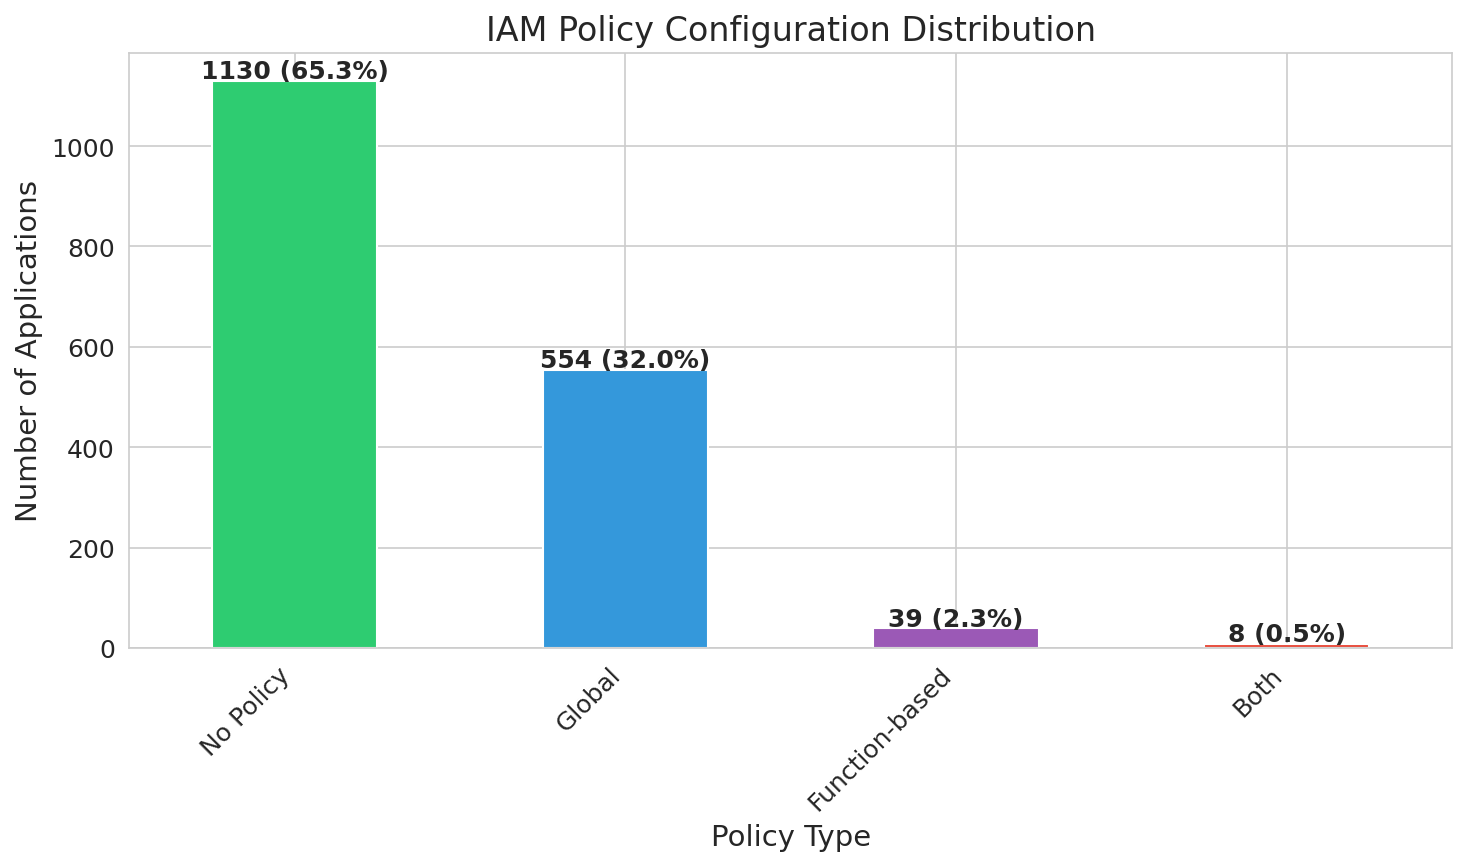

In [33]:
# Create a categorical policy type column
def get_policy_type(row):
    if row['has_no_iam_statements']:
        return 'No Policy'
    elif row['has_both_global_and_function_iam_statements']:
        return 'Both'
    elif row['has_global_iam_statements']:
        return 'Global'
    elif row['has_function_level_iam_statements']:
        return 'Function-based'
    return 'Unknown'

df['policy_type'] = df.apply(get_policy_type, axis=1)

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 6))
policy_counts = df['policy_type'].value_counts()
policy_counts.plot(kind='bar', ax=ax, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
ax.set_title('IAM Policy Configuration Distribution', fontsize=16)
ax.set_xlabel('Policy Type', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(policy_counts):
    ax.text(i, v + 5, f'{v} ({v/len(df)*100:.1f}%)', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Filter to Apps with Policies

From this point forward, we analyze only applications that have IAM policies defined.

In [34]:
# Filter to only apps with IAM policies
df_policies = df[~df['has_no_iam_statements']].copy()
print(f"Apps with IAM policies: {len(df_policies)} out of {len(df)} total ({len(df_policies)/len(df)*100:.1f}%)")
print(f"Apps without policies (excluded): {df['has_no_iam_statements'].sum()}")

# Show breakdown of policy types in filtered data
print(f"\nPolicy type breakdown (apps with policies only):")
print(df_policies['policy_type'].value_counts())

Apps with IAM policies: 601 out of 1731 total (34.7%)
Apps without policies (excluded): 1130

Policy type breakdown (apps with policies only):
policy_type
Global            554
Function-based     39
Both                8
Name: count, dtype: int64


In [35]:
# Run once - to get the path of apps with policies
# save paths to new json file
policy_app_paths = df_policies['app_path'].tolist()
with open('/mnt/nfs/home/eyeboahduako/privilege-analyzer/apps/dataset/apps_with_policies.json', 'w') as f:
    json.dump(policy_app_paths, f)

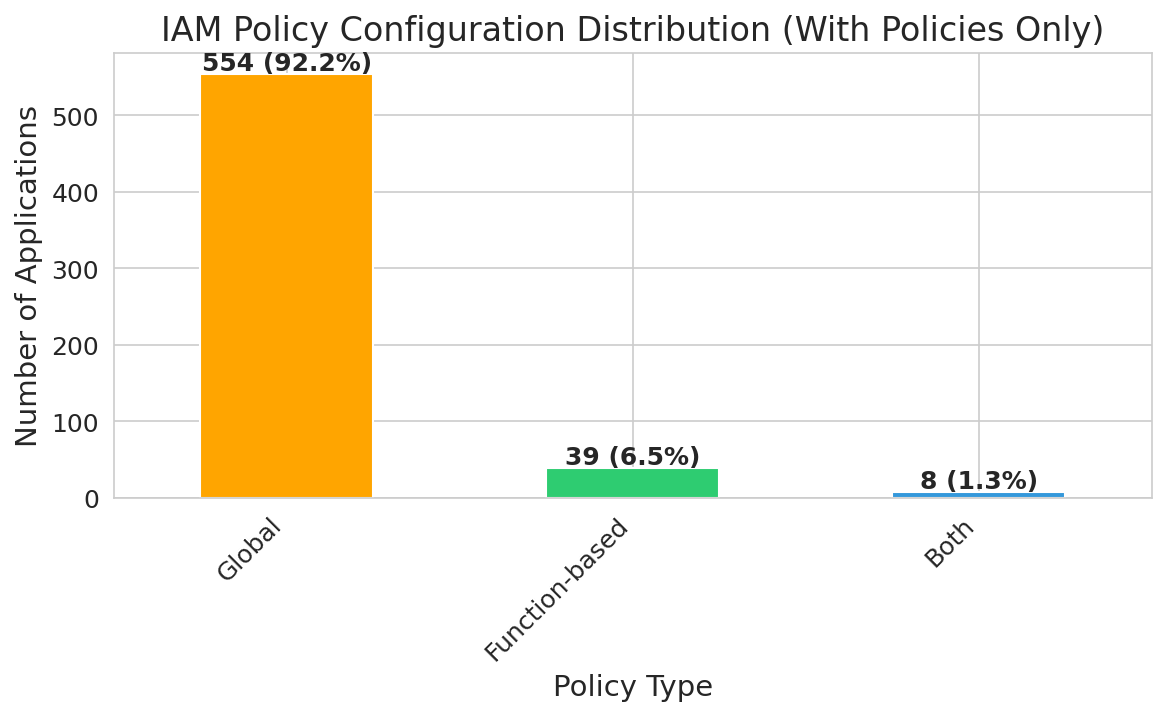

In [36]:
# visualize the policy type breakdown for apps with policies only
fig, ax = plt.subplots(figsize=(8, 5))
policy_counts_filtered = df_policies['policy_type'].value_counts()
policy_counts_filtered.plot(kind='bar', ax=ax, color=['#FFA500','#2ecc71', '#3498db'])
ax.set_title('IAM Policy Configuration Distribution (With Policies Only)', fontsize=16)
ax.set_xlabel('Policy Type', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.xticks(rotation=45, ha='right')
# Add value labels on bars
for i, v in enumerate(policy_counts_filtered):
    ax.text(i, v + 5, f'{v} ({v/len(df_policies)*100:.1f}%)', ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

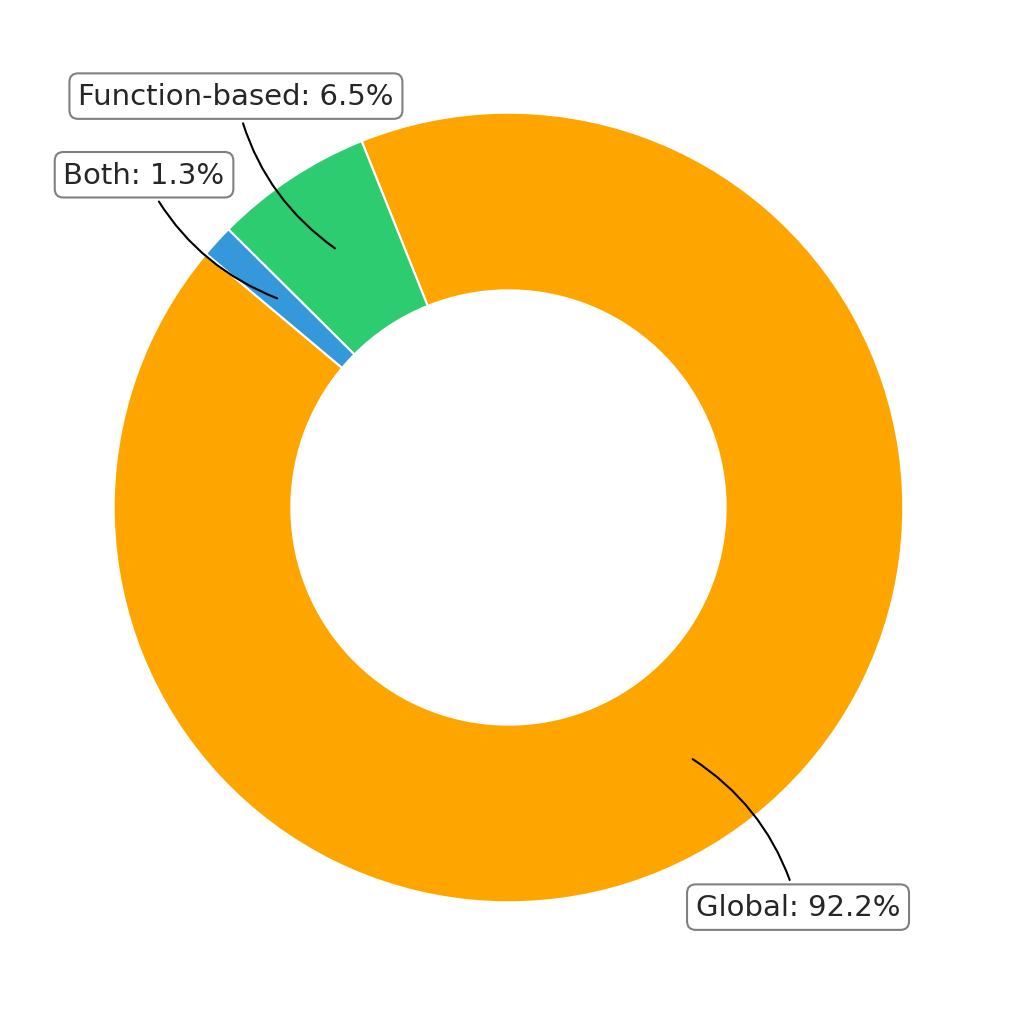

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))

colors = ['#FFA500', '#2ecc71', '#3498db']

wedges, _ = ax.pie(
    policy_counts_filtered,
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.45)  # donut thickness
)

total = policy_counts_filtered.sum()

for i, w in enumerate(wedges):
    ang = (w.theta2 + w.theta1) / 2
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    pct = policy_counts_filtered.iloc[i] / total * 100
    label = f"{policy_counts_filtered.index[i]}: {pct:.1f}%"

    # Position text outside
    ax.annotate(
        label,
        xy=(x * 0.78, y * 0.78),          # arrow starts near slice
        xytext=(x * 1.25, y * 1.25),      # text outside
        ha='center',
        va='center',
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"),
        arrowprops=dict(
            arrowstyle='-',
            color ='black',
            connectionstyle="arc3,rad=0.2"  # curved line like reference
        )
    )

#ax.set_title("Distribution of Serverless Policy Definitions", pad=20)
ax.set_aspect('equal')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Extract and Flatten Analysis Metrics

Flatten the nested `analysis_metrics` field for easier analysis.

In [38]:
# Flatten analysis_metrics into separate columns (for apps with policies)
metrics_df = pd.json_normalize(df_policies['analysis_metrics'])
metrics_df.columns = ['metrics_' + col for col in metrics_df.columns]

# Combine with filtered df
df_flat = pd.concat([df_policies.drop('analysis_metrics', axis=1).reset_index(drop=True), metrics_df], axis=1)

print("Flattened metrics columns:")
print([col for col in df_flat.columns if col.startswith('metrics_')])

Flattened metrics columns:
['metrics_total_functions', 'metrics_total_service_calls', 'metrics_unique_services', 'metrics_service_count', 'metrics_total_resources', 'metrics_resolved_resources', 'metrics_unresolved_resources', 'metrics_resolution_rate', 'metrics_total_statements', 'metrics_total_permissions']


## 4. Action Wildcard Analysis

Analyze the use of wildcards in IAM **actions/permissions** (e.g., `s3:*`, `dynamodb:Get*`).

In [39]:
# Flatten action_wildcard_analysis (for apps with policies)
action_wildcard_df = pd.json_normalize(df_policies['action_wildcard_analysis'])
action_wildcard_df.columns = ['action_' + col for col in action_wildcard_df.columns]

# Key action wildcard metrics
print(f"Action Wildcard Usage Summary (among {len(df_policies)} apps with policies):")
print(f"Apps with any action wildcard: {action_wildcard_df['action_has_any_wildcard'].sum()} ({action_wildcard_df['action_has_any_wildcard'].mean()*100:.1f}%)")
print(f"Apps with full wildcard (*): {action_wildcard_df['action_has_full_wildcard'].sum()} ({action_wildcard_df['action_has_full_wildcard'].mean()*100:.1f}%)")
print(f"Apps with service wildcard (service:*): {action_wildcard_df['action_has_service_wildcard'].sum()} ({action_wildcard_df['action_has_service_wildcard'].mean()*100:.1f}%)")
print(f"Apps with prefix wildcard (service:Get*): {action_wildcard_df['action_has_prefix_wildcard'].sum()} ({action_wildcard_df['action_has_prefix_wildcard'].mean()*100:.1f}%)")

Action Wildcard Usage Summary (among 601 apps with policies):
Apps with any action wildcard: 146 (24.3%)
Apps with full wildcard (*): 6 (1.0%)
Apps with service wildcard (service:*): 130 (21.6%)
Apps with prefix wildcard (service:Get*): 15 (2.5%)


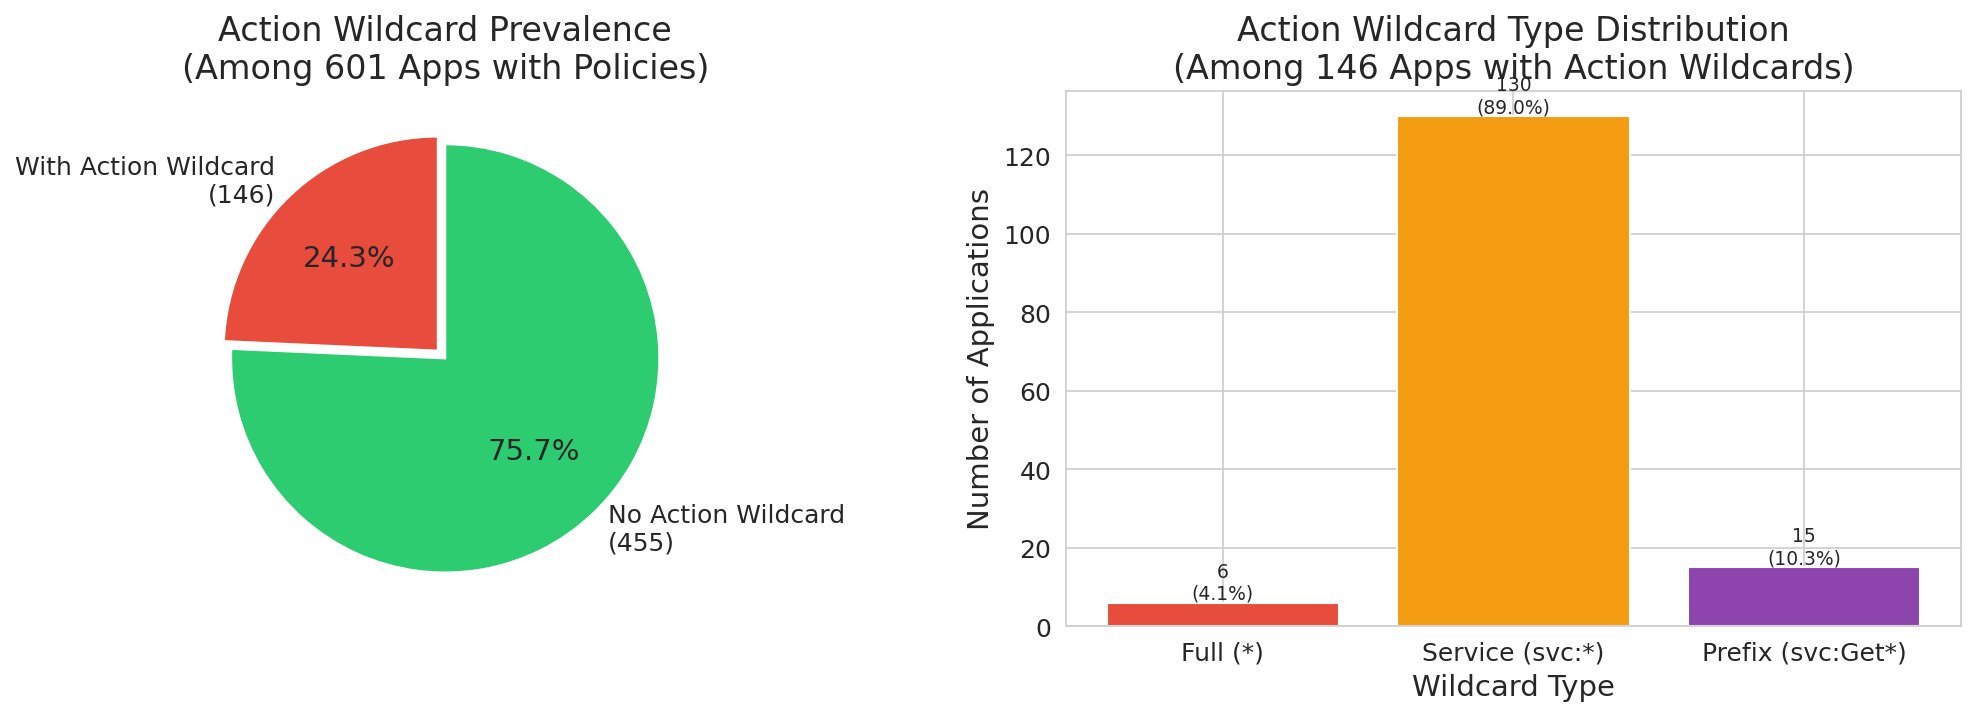


Note: An app can have multiple wildcard types simultaneously.
  - Full wildcards: 6 of 146 apps with wildcards (4.1%)
  - Service wildcards: 130 of 146 apps with wildcards (89.0%)
  - Prefix wildcards: 15 of 146 apps with wildcards (10.3%)


In [40]:
# Visualize action wildcard distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Pie chart showing apps WITH vs WITHOUT action wildcards
total_with_action_wildcard = action_wildcard_df['action_has_any_wildcard'].sum()
total_without_action_wildcard = len(df_policies) - total_with_action_wildcard
sizes = [total_with_action_wildcard, total_without_action_wildcard]
labels = [f'With Action Wildcard\n({total_with_action_wildcard})', f'No Action Wildcard\n({total_without_action_wildcard})']
colors = ['#e74c3c', '#2ecc71']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0))
axes[0].set_title(f'Action Wildcard Prevalence\n(Among {len(df_policies)} Apps with Policies)')

# Right: Bar chart of wildcard TYPE distribution (among apps WITH wildcards only)
# Percentages are relative to apps that have ANY action wildcard
wildcard_types = {
    'Full (*)': action_wildcard_df['action_has_full_wildcard'].sum(),
    'Service (svc:*)': action_wildcard_df['action_has_service_wildcard'].sum(),
    'Prefix (svc:Get*)': action_wildcard_df['action_has_prefix_wildcard'].sum()
}

bars = axes[1].bar(wildcard_types.keys(), wildcard_types.values(), color=['#e74c3c', '#f39c12', '#8e44ad'])
axes[1].set_title(f'Action Wildcard Type Distribution\n(Among {total_with_action_wildcard} Apps with Action Wildcards)')
axes[1].set_xlabel('Wildcard Type')
axes[1].set_ylabel('Number of Applications')

for bar in bars:
    height = bar.get_height()
    # Calculate percentage relative to apps WITH any action wildcard
    pct = (height / total_with_action_wildcard) * 100 if total_with_action_wildcard > 0 else 0
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}\n({pct:.1f}%)', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nNote: An app can have multiple wildcard types simultaneously.")
print(f"  - Full wildcards: {wildcard_types['Full (*)']} of {total_with_action_wildcard} apps with wildcards ({wildcard_types['Full (*)'] / total_with_action_wildcard * 100:.1f}%)")
print(f"  - Service wildcards: {wildcard_types['Service (svc:*)']} of {total_with_action_wildcard} apps with wildcards ({wildcard_types['Service (svc:*)'] / total_with_action_wildcard * 100:.1f}%)")
print(f"  - Prefix wildcards: {wildcard_types['Prefix (svc:Get*)']} of {total_with_action_wildcard} apps with wildcards ({wildcard_types['Prefix (svc:Get*)'] / total_with_action_wildcard * 100:.1f}%)")

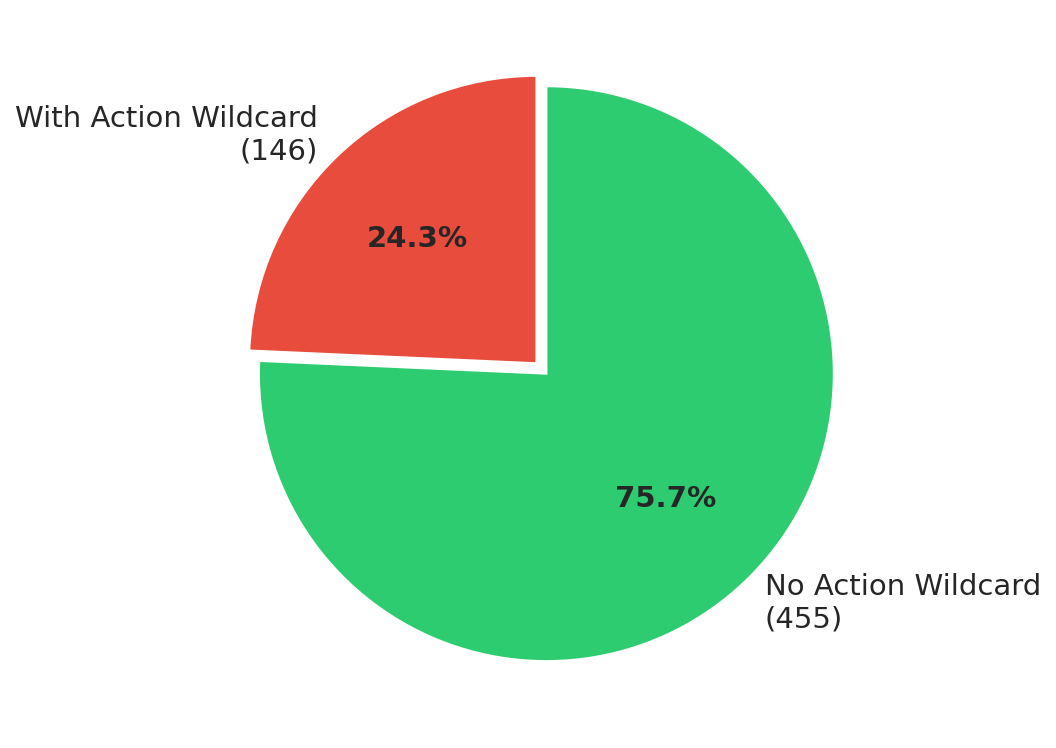

In [41]:
#Separating graphs for double columns

total_with_action_wildcard = action_wildcard_df['action_has_any_wildcard'].sum()
total_without_action_wildcard = len(df_policies) - total_with_action_wildcard

sizes = [total_with_action_wildcard, total_without_action_wildcard]
labels = [
    f'With Action Wildcard\n({total_with_action_wildcard})',
    f'No Action Wildcard\n({total_without_action_wildcard})'
]
colors = ['#e74c3c', '#2ecc71']

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0),
    textprops={'fontsize': 14}
)

# Make percentage text larger
for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

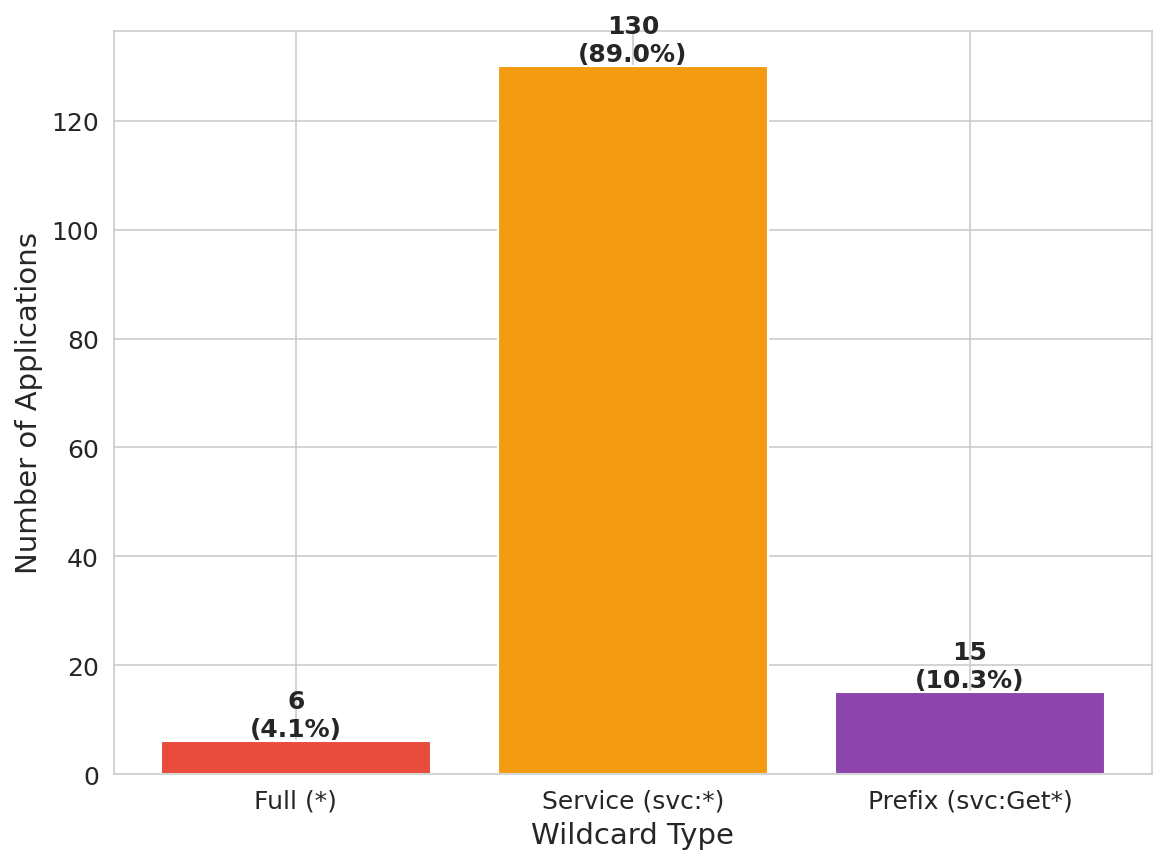

In [42]:
wildcard_types = {
    'Full (*)': action_wildcard_df['action_has_full_wildcard'].sum(),
    'Service (svc:*)': action_wildcard_df['action_has_service_wildcard'].sum(),
    'Prefix (svc:Get*)': action_wildcard_df['action_has_prefix_wildcard'].sum()
}

total_with_action_wildcard = action_wildcard_df['action_has_any_wildcard'].sum()

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    wildcard_types.keys(),
    wildcard_types.values(),
    color=['#e74c3c', '#f39c12', '#8e44ad']
)

ax.set_xlabel('Wildcard Type', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

for bar in bars:
    height = bar.get_height()
    pct = (height / total_with_action_wildcard) * 100 if total_with_action_wildcard > 0 else 0
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{int(height)}\n({pct:.1f}%)',
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

## 5. Resource Wildcard Analysis

Analyze the use of wildcards in IAM **resources** (e.g., `arn:aws:s3:::*`, `arn:aws:dynamodb:*:*:table/*`).

In [43]:
# Flatten resource_wildcard_analysis (for apps with policies)
resource_wildcard_df = pd.json_normalize(df_policies['resource_wildcard_analysis'])
resource_wildcard_df.columns = ['resource_' + col for col in resource_wildcard_df.columns]

# Key resource wildcard metrics
print(f"Resource Wildcard Usage Summary (among {len(df_policies)} apps with policies):")
print(f"Apps with any resource wildcard: {resource_wildcard_df['resource_has_any_wildcard'].sum()} ({resource_wildcard_df['resource_has_any_wildcard'].mean()*100:.1f}%)")
print(f"Apps with full wildcard (*): {resource_wildcard_df['resource_has_full_wildcard'].sum()} ({resource_wildcard_df['resource_has_full_wildcard'].mean()*100:.1f}%)")
print(f"Apps with service wildcard (arn:...:*): {resource_wildcard_df['resource_has_service_wildcard'].sum()} ({resource_wildcard_df['resource_has_service_wildcard'].mean()*100:.1f}%)")
print(f"Apps with prefix wildcard (arn:...prefix*): {resource_wildcard_df['resource_has_prefix_wildcard'].sum()} ({resource_wildcard_df['resource_has_prefix_wildcard'].mean()*100:.1f}%)")

Resource Wildcard Usage Summary (among 601 apps with policies):
Apps with any resource wildcard: 493 (82.0%)
Apps with full wildcard (*): 278 (46.3%)
Apps with service wildcard (arn:...:*): 121 (20.1%)
Apps with prefix wildcard (arn:...prefix*): 199 (33.1%)


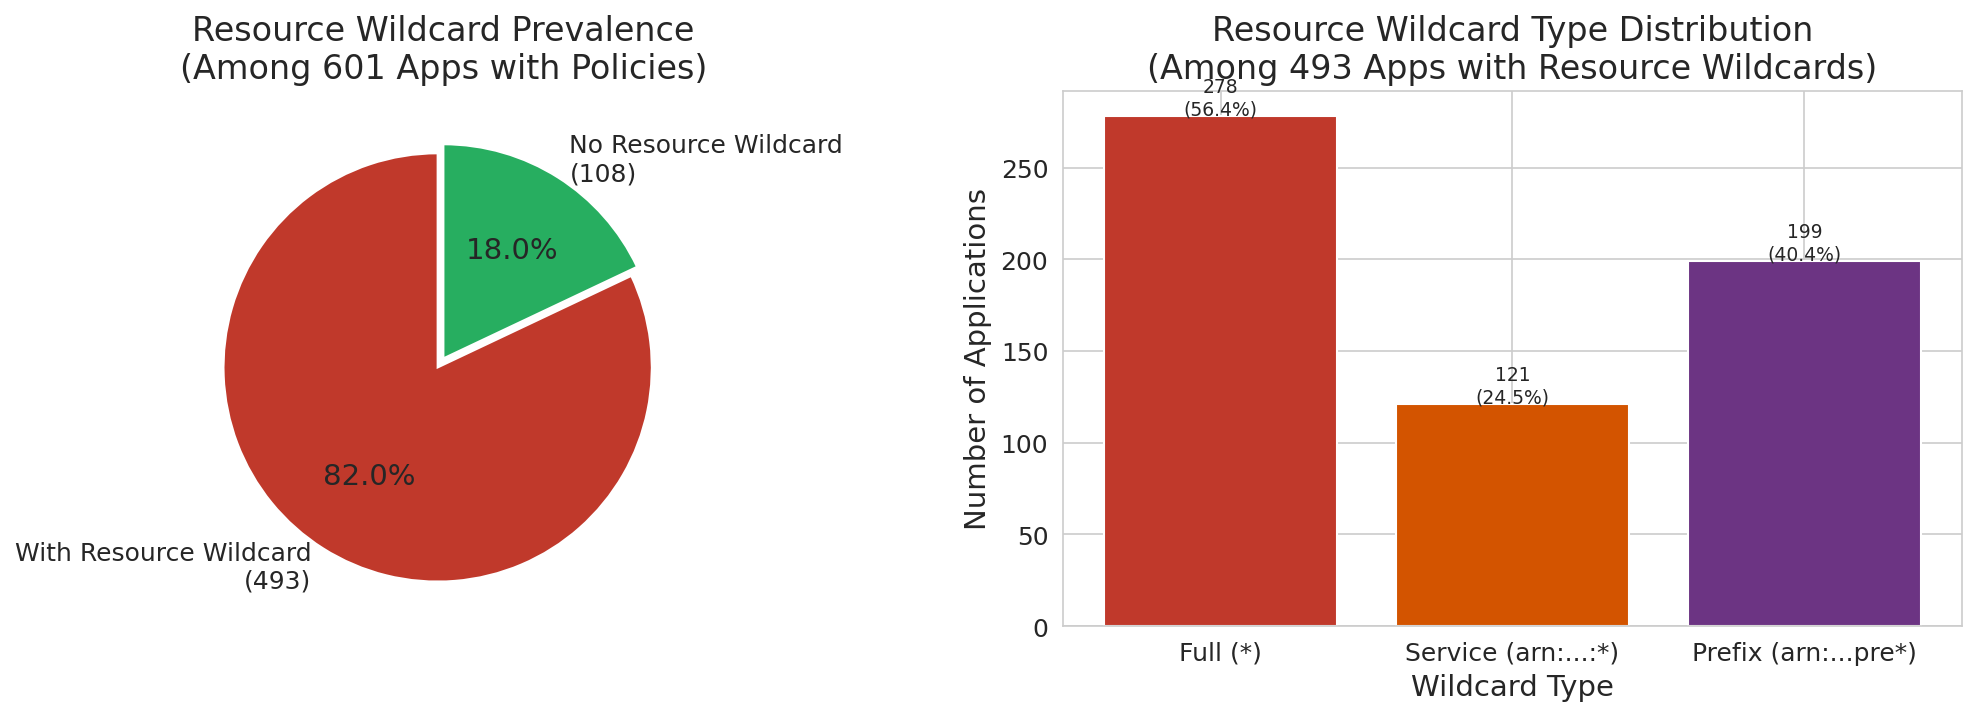


Note: An app can have multiple wildcard types simultaneously.
  - Full wildcards: 278 of 493 apps with wildcards (56.4%)
  - Service wildcards: 121 of 493 apps with wildcards (24.5%)
  - Prefix wildcards: 199 of 493 apps with wildcards (40.4%)


In [44]:
# Visualize resource wildcard distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Pie chart showing apps WITH vs WITHOUT resource wildcards
total_with_resource_wildcard = resource_wildcard_df['resource_has_any_wildcard'].sum()
total_without_resource_wildcard = len(df_policies) - total_with_resource_wildcard
sizes = [total_with_resource_wildcard, total_without_resource_wildcard]
labels = [f'With Resource Wildcard\n({total_with_resource_wildcard})', f'No Resource Wildcard\n({total_without_resource_wildcard})']
colors = ['#c0392b', '#27ae60']
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=(0.05, 0))
axes[0].set_title(f'Resource Wildcard Prevalence\n(Among {len(df_policies)} Apps with Policies)')

# Right: Bar chart of wildcard TYPE distribution (among apps WITH wildcards only)
# Percentages are relative to apps that have ANY resource wildcard
resource_wildcard_types = {
    'Full (*)': resource_wildcard_df['resource_has_full_wildcard'].sum(),
    'Service (arn:...:*)': resource_wildcard_df['resource_has_service_wildcard'].sum(),
    'Prefix (arn:...pre*)': resource_wildcard_df['resource_has_prefix_wildcard'].sum()
}

bars = axes[1].bar(resource_wildcard_types.keys(), resource_wildcard_types.values(), color=['#c0392b', '#d35400', '#6c3483'])
axes[1].set_title(f'Resource Wildcard Type Distribution\n(Among {total_with_resource_wildcard} Apps with Resource Wildcards)')
axes[1].set_xlabel('Wildcard Type')
axes[1].set_ylabel('Number of Applications')

for bar in bars:
    height = bar.get_height()
    # Calculate percentage relative to apps WITH any resource wildcard
    pct = (height / total_with_resource_wildcard) * 100 if total_with_resource_wildcard > 0 else 0
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}\n({pct:.1f}%)', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nNote: An app can have multiple wildcard types simultaneously.")
if total_with_resource_wildcard > 0:
    print(f"  - Full wildcards: {resource_wildcard_types['Full (*)']} of {total_with_resource_wildcard} apps with wildcards ({resource_wildcard_types['Full (*)'] / total_with_resource_wildcard * 100:.1f}%)")
    print(f"  - Service wildcards: {resource_wildcard_types['Service (arn:...:*)']} of {total_with_resource_wildcard} apps with wildcards ({resource_wildcard_types['Service (arn:...:*)'] / total_with_resource_wildcard * 100:.1f}%)")
    print(f"  - Prefix wildcards: {resource_wildcard_types['Prefix (arn:...pre*)']} of {total_with_resource_wildcard} apps with wildcards ({resource_wildcard_types['Prefix (arn:...pre*)'] / total_with_resource_wildcard * 100:.1f}%)")
else:
    print("  No apps with resource wildcards found.")

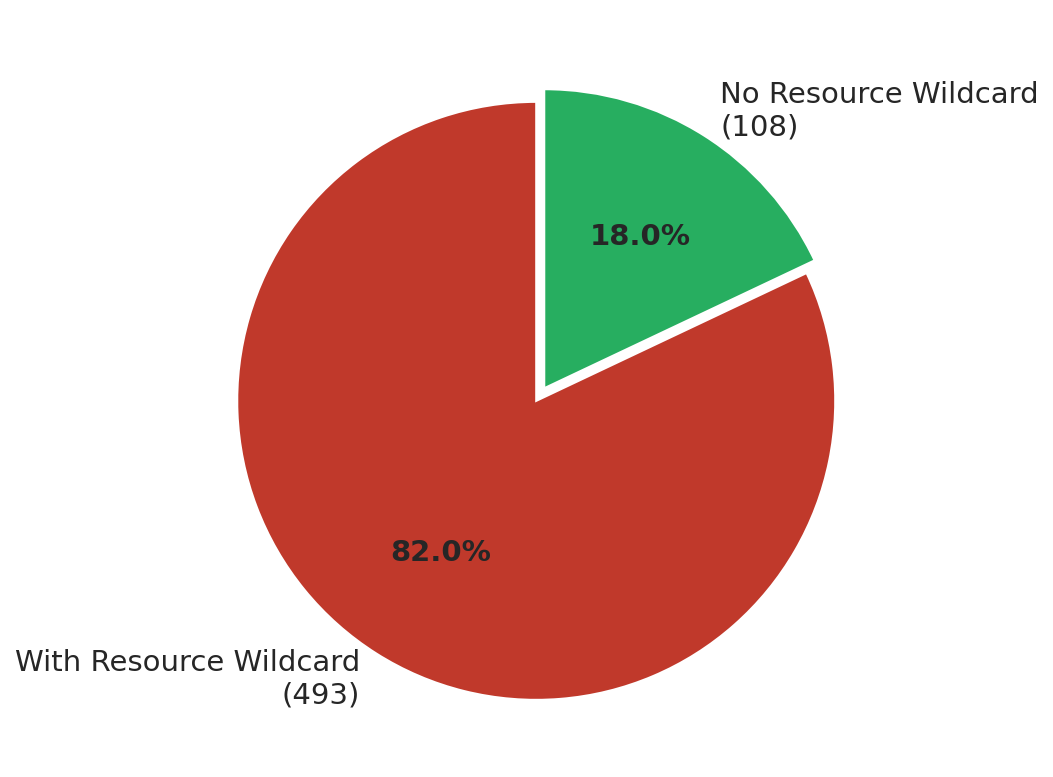

In [45]:
# separating

total_with_resource_wildcard = resource_wildcard_df['resource_has_any_wildcard'].sum()
total_without_resource_wildcard = len(df_policies) - total_with_resource_wildcard

sizes = [total_with_resource_wildcard, total_without_resource_wildcard]
labels = [
    f'With Resource Wildcard\n({total_with_resource_wildcard})',
    f'No Resource Wildcard\n({total_without_resource_wildcard})'
]
colors = ['#c0392b', '#27ae60']

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0),
    textprops={'fontsize': 14}
)

# Make percentage text larger
for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

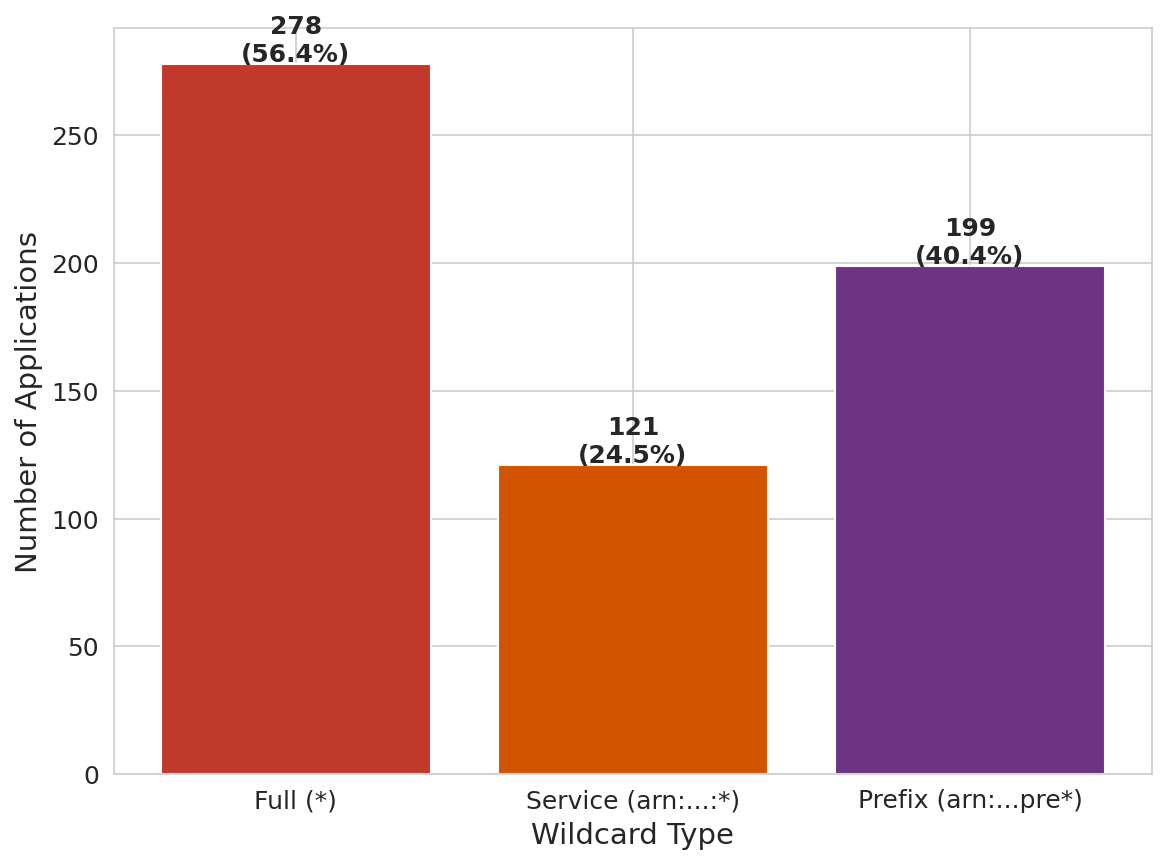

In [46]:
resource_wildcard_types = {
    'Full (*)': resource_wildcard_df['resource_has_full_wildcard'].sum(),
    'Service (arn:...:*)': resource_wildcard_df['resource_has_service_wildcard'].sum(),
    'Prefix (arn:...pre*)': resource_wildcard_df['resource_has_prefix_wildcard'].sum()
}

total_with_resource_wildcard = resource_wildcard_df['resource_has_any_wildcard'].sum()

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(
    resource_wildcard_types.keys(),
    resource_wildcard_types.values(),
    color=['#c0392b', '#d35400', '#6c3483']
)

ax.set_xlabel('Wildcard Type', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

for bar in bars:
    height = bar.get_height()
    pct = (height / total_with_resource_wildcard) * 100 if total_with_resource_wildcard > 0 else 0
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{int(height)}\n({pct:.1f}%)',
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

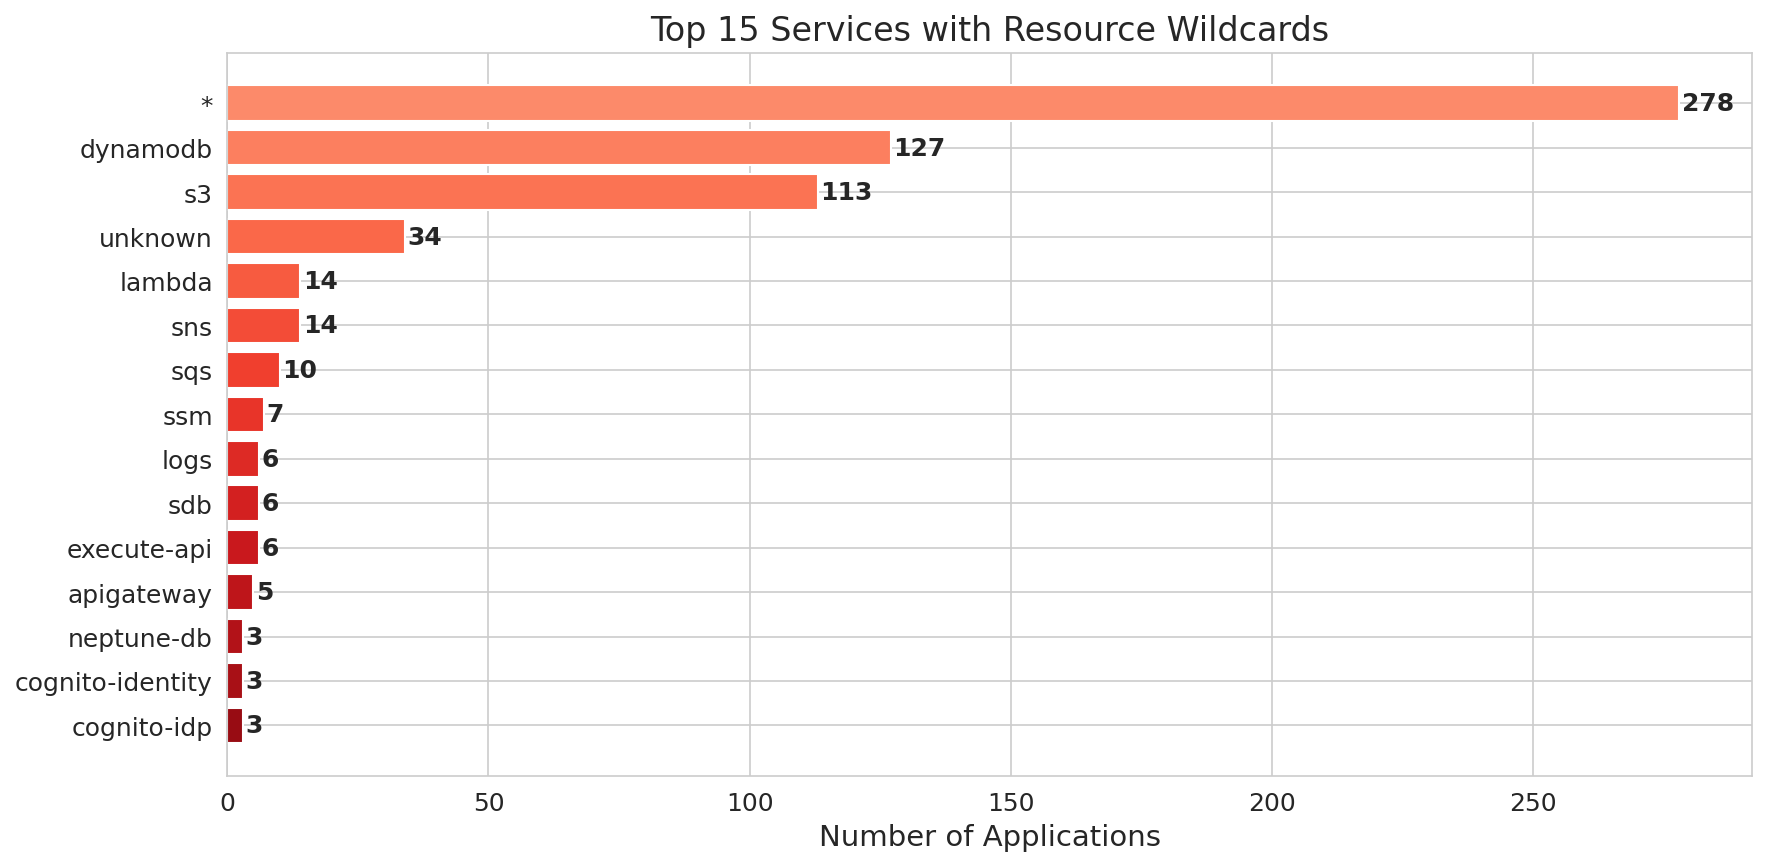


Total services with resource wildcards: 25


In [47]:
# Analyze services with resource wildcards
all_services_with_resource_wildcards = []
for idx, row in df_policies.iterrows():
    if isinstance(row['resource_wildcard_analysis'], dict):
        services = row['resource_wildcard_analysis'].get('services_with_wildcards', [])
        all_services_with_resource_wildcards.extend(services)

if all_services_with_resource_wildcards:
    service_wildcard_counts = pd.Series(all_services_with_resource_wildcards).value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    top_services = service_wildcard_counts.head(15)
    bars = ax.barh(range(len(top_services)), top_services.values, color=plt.cm.Reds(np.linspace(0.4, 0.9, len(top_services))))
    ax.set_yticks(range(len(top_services)))
    ax.set_yticklabels(top_services.index, fontsize=12)
    ax.set_xlabel('Number of Applications', fontsize=14)
    ax.set_title('Top 15 Services with Resource Wildcards', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.invert_yaxis()
    
    for i, v in enumerate(top_services.values):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal services with resource wildcards: {len(service_wildcard_counts)}")
else:
    print("No services with resource wildcards found")

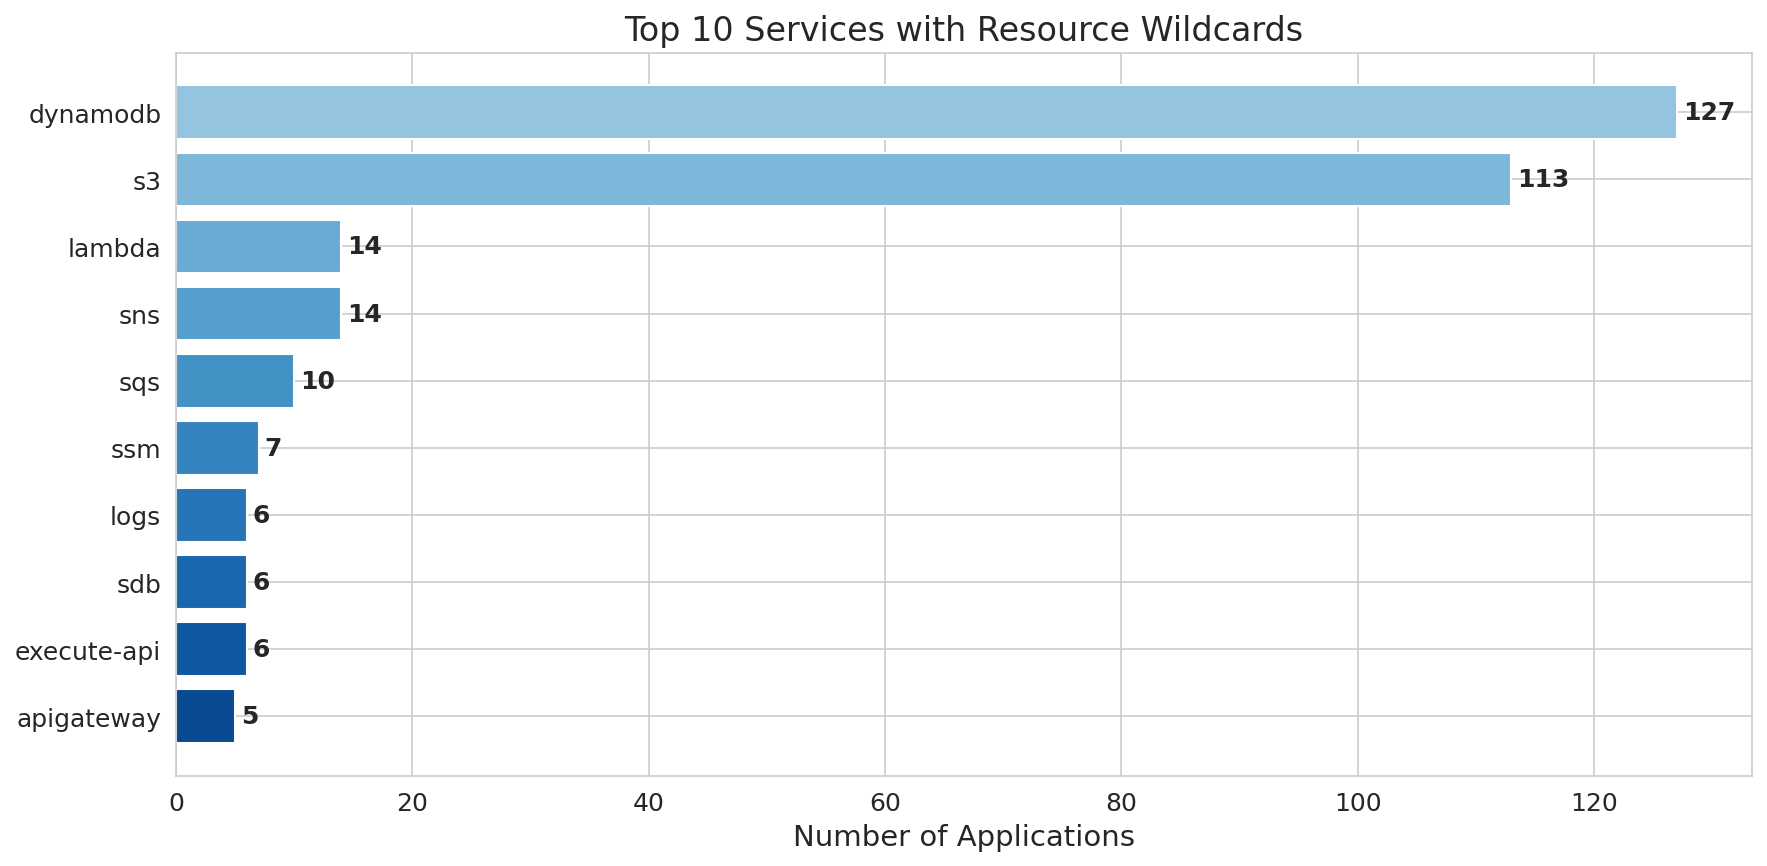


Total services with resource wildcards (excluding '*'): 23


In [48]:
# repeat the analysis from the cell above but don't include the service '*'
# Analyze services with resource wildcards (excluding '*' and 'unknown')
all_services_with_resource_wildcards_excl_star = []
for idx, row in df_policies.iterrows():
    if isinstance(row['resource_wildcard_analysis'], dict):
        services = row['resource_wildcard_analysis'].get('services_with_wildcards', [])
        # Exclude the wildcard '*' and 'unknown'
        services = [svc for svc in services if svc != '*' and svc != 'unknown']
        services = [svc for svc in services if svc != '*']
        all_services_with_resource_wildcards_excl_star.extend(services) 
if all_services_with_resource_wildcards_excl_star:
    service_wildcard_counts_excl_star = pd.Series(all_services_with_resource_wildcards_excl_star).value_counts()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    top_services_excl_star = service_wildcard_counts_excl_star.head(10)
    bars = ax.barh(range(len(top_services_excl_star)), top_services_excl_star.values, color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_services_excl_star))))
    ax.set_yticks(range(len(top_services_excl_star)))
    ax.set_yticklabels(top_services_excl_star.index, fontsize=12)
    ax.set_xlabel('Number of Applications', fontsize=14)
    ax.set_title('Top 10 Services with Resource Wildcards', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.invert_yaxis()
    
    for i, v in enumerate(top_services_excl_star.values):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal services with resource wildcards (excluding '*'): {len(service_wildcard_counts_excl_star)}")
else:
    print("No services with resource wildcards found (excluding '*')")
# --- IGNORE --- 

## 6. Action vs Resource Wildcard Comparison

Compare the prevalence and types of wildcards in actions versus resources.

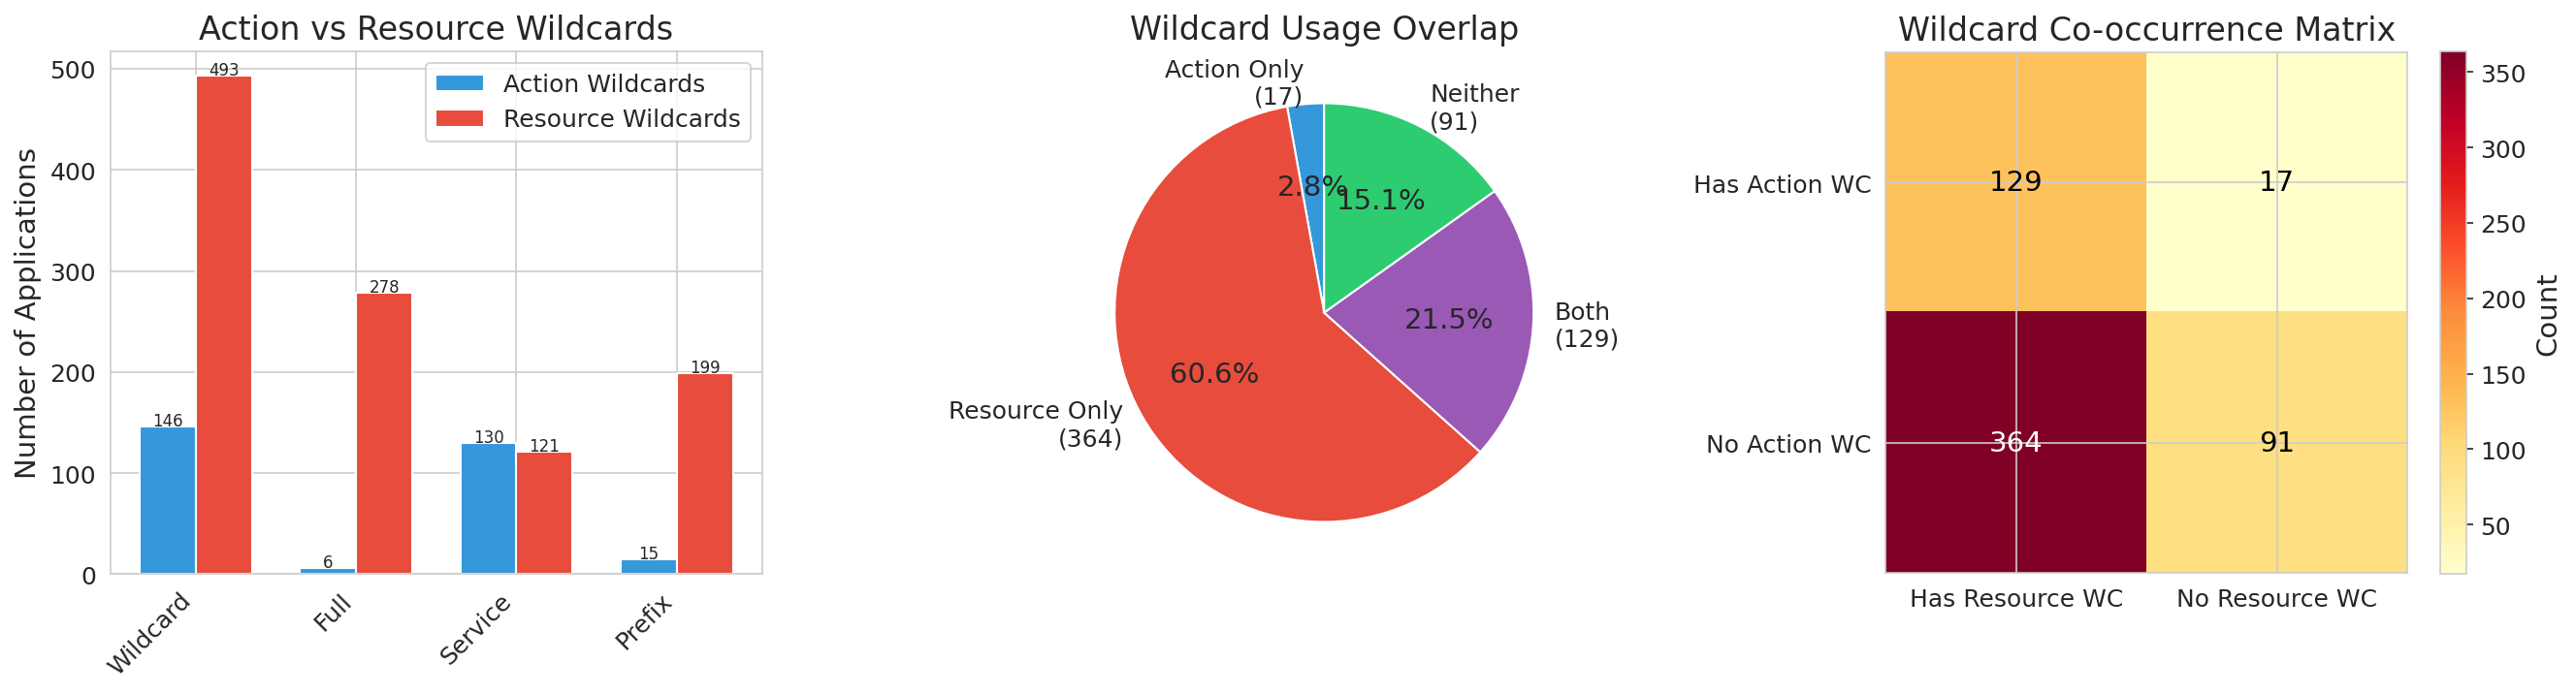


Summary:
  Apps with action wildcards only: 17 (2.8%)
  Apps with resource wildcards only: 364 (60.6%)
  Apps with both: 129 (21.5%)
  Apps with neither: 91 (15.1%)


In [49]:
# Side-by-side comparison of action vs resource wildcards
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Comparison data
categories = ['Wildcard', 'Full', 'Service', 'Prefix']
action_values = [
    action_wildcard_df['action_has_any_wildcard'].sum(),
    action_wildcard_df['action_has_full_wildcard'].sum(),
    action_wildcard_df['action_has_service_wildcard'].sum(),
    action_wildcard_df['action_has_prefix_wildcard'].sum()
]
resource_values = [
    resource_wildcard_df['resource_has_any_wildcard'].sum(),
    resource_wildcard_df['resource_has_full_wildcard'].sum(),
    resource_wildcard_df['resource_has_service_wildcard'].sum(),
    resource_wildcard_df['resource_has_prefix_wildcard'].sum()
]

# Left: Grouped bar chart
x = np.arange(len(categories))
width = 0.35
bars1 = axes[0].bar(x - width/2, action_values, width, label='Action Wildcards', color='#3498db')
bars2 = axes[0].bar(x + width/2, resource_values, width, label='Resource Wildcards', color='#e74c3c')
axes[0].set_ylabel('Number of Applications')
axes[0].set_title('Action vs Resource Wildcards')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=45, ha='right')
axes[0].legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', fontsize=8)

# Middle: Stacked bar showing overlap
both = ((action_wildcard_df['action_has_any_wildcard']) & (resource_wildcard_df['resource_has_any_wildcard'])).sum()
action_only = action_wildcard_df['action_has_any_wildcard'].sum() - both
resource_only = resource_wildcard_df['resource_has_any_wildcard'].sum() - both
neither = len(df_policies) - both - action_only - resource_only

overlap_data = [action_only, resource_only, both, neither]
overlap_labels = [f'Action Only\n({action_only})', f'Resource Only\n({resource_only})', 
                  f'Both\n({both})', f'Neither\n({neither})']
colors = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']
axes[1].pie(overlap_data, labels=overlap_labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Wildcard Usage Overlap')

# Right: Heatmap-style matrix
matrix_data = np.array([
    [both, action_only],
    [resource_only, neither]
])
im = axes[2].imshow(matrix_data, cmap='YlOrRd')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['Has Resource WC', 'No Resource WC'])
axes[2].set_yticklabels(['Has Action WC', 'No Action WC'])
axes[2].set_title('Wildcard Co-occurrence Matrix')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = axes[2].text(j, i, matrix_data[i, j], ha='center', va='center', 
                           color='white' if matrix_data[i, j] > matrix_data.max()/2 else 'black', fontsize=14)

plt.colorbar(im, ax=axes[2], label='Count')
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Apps with action wildcards only: {action_only} ({action_only/len(df_policies)*100:.1f}%)")
print(f"  Apps with resource wildcards only: {resource_only} ({resource_only/len(df_policies)*100:.1f}%)")
print(f"  Apps with both: {both} ({both/len(df_policies)*100:.1f}%)")
print(f"  Apps with neither: {neither} ({neither/len(df_policies)*100:.1f}%)")

Apps with BOTH action and resource wildcards: 129
This is 21.5% of apps with policies

WILDCARD PERMUTATION ANALYSIS
(Among 129 apps with both action and resource wildcards)

                      Combination  Count Percentage
      Full Action + Full Resource      2       1.6%
   Full Action + Service Resource      1       0.8%
    Full Action + Prefix Resource      2       1.6%
   Service Action + Full Resource     95      73.6%
Service Action + Service Resource     24      18.6%
 Service Action + Prefix Resource     36      27.9%
    Prefix Action + Full Resource     13      10.1%
 Prefix Action + Service Resource      2       1.6%
  Prefix Action + Prefix Resource      7       5.4%


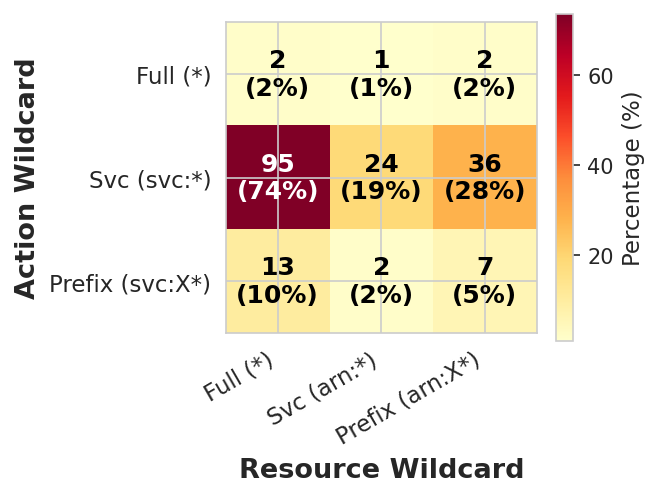


KEY INSIGHTS
• Most common combination: Service Action + Full Resource
  - 95 apps (73.6% of apps with both wildcards)

• Highest risk (Full Action + Full Resource): 2 apps (1.6%)

• Apps with service-level action wildcards (svc:*): 114 (88.4%)


In [50]:
# Wildcard Permutation Analysis
# For apps with BOTH action and resource wildcards, analyze all combinations of wildcard types

# First, combine action and resource wildcard dataframes with the main data
combined_wc_df = pd.concat([
    df_policies[['app_name']].reset_index(drop=True),
    action_wildcard_df.reset_index(drop=True),
    resource_wildcard_df.reset_index(drop=True)
], axis=1)

# Filter to apps that have BOTH action AND resource wildcards
apps_with_both = combined_wc_df[
    (combined_wc_df['action_has_any_wildcard'] == True) & 
    (combined_wc_df['resource_has_any_wildcard'] == True)
].copy()

print(f"Apps with BOTH action and resource wildcards: {len(apps_with_both)}")
print(f"This is {len(apps_with_both)/len(df_policies)*100:.1f}% of apps with policies")
print()

# Define wildcard types
action_types = ['full', 'service', 'prefix']
resource_types = ['full', 'service', 'prefix']

# Create a matrix to count combinations
permutation_counts = {}
permutation_matrix = np.zeros((3, 3), dtype=int)

for i, action_type in enumerate(action_types):
    for j, resource_type in enumerate(resource_types):
        action_col = f'action_has_{action_type}_wildcard'
        resource_col = f'resource_has_{resource_type}_wildcard'
        
        # Count apps that have this specific combination
        count = ((apps_with_both[action_col] == True) & 
                 (apps_with_both[resource_col] == True)).sum()
        
        key = f'{action_type.capitalize()} Action + {resource_type.capitalize()} Resource'
        permutation_counts[key] = count
        permutation_matrix[i, j] = count

# Calculate percentages relative to apps with both wildcards
total_both = len(apps_with_both)
print("=" * 70)
print("WILDCARD PERMUTATION ANALYSIS")
print(f"(Among {total_both} apps with both action and resource wildcards)")
print("=" * 70)
print()

# Create a results dataframe
results = []
for combo, count in permutation_counts.items():
    pct = (count / total_both * 100) if total_both > 0 else 0
    results.append({
        'Combination': combo,
        'Count': count,
        'Percentage': f'{pct:.1f}%'
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Create COMPACT single-column heatmap for IEEE template
# Using percentage matrix for a cleaner single visualization
permutation_pct_matrix = (permutation_matrix / total_both * 100) if total_both > 0 else permutation_matrix

# Single-column IEEE figure (approx 3.5 inches wide)
fig, ax = plt.subplots(figsize=(4.5, 4))

# Shorter labels to fit single column
action_labels = ['Full (*)', 'Svc (svc:*)', 'Prefix (svc:X*)']
resource_labels = ['Full (*)', 'Svc (arn:*)', 'Prefix (arn:X*)']

im = ax.imshow(permutation_pct_matrix, cmap='YlOrRd')

ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(resource_labels, fontsize=11, rotation=30, ha='right')
ax.set_yticklabels(action_labels, fontsize=11)
ax.set_xlabel('Resource Wildcard', fontsize=13, fontweight='bold')
ax.set_ylabel('Action Wildcard', fontsize=13, fontweight='bold')

# Add text annotations with both count and percentage
for i in range(3):
    for j in range(3):
        count = permutation_matrix[i, j]
        pct = permutation_pct_matrix[i, j]
        color = 'white' if pct > permutation_pct_matrix.max() / 2 else 'black'
        ax.text(j, i, f'{count}\n({pct:.0f}%)', ha='center', va='center', 
                color=color, fontsize=12, fontweight='bold')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Percentage (%)', fontsize=11)
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

# Print summary insights
print()
print("=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

# Find most common combination
sorted_results = sorted(permutation_counts.items(), key=lambda x: x[1], reverse=True)
if sorted_results:
    most_common = sorted_results[0]
    print(f"• Most common combination: {most_common[0]}")
    print(f"  - {most_common[1]} apps ({most_common[1]/total_both*100:.1f}% of apps with both wildcards)")

# Check for "worst" case: full action + full resource
full_full = permutation_counts.get('Full Action + Full Resource', 0)
print(f"\n• Highest risk (Full Action + Full Resource): {full_full} apps ({full_full/total_both*100:.1f}%)")

# Apps with service-level action wildcards (any resource type)
service_action_any = sum(1 for i, row in apps_with_both.iterrows() if row['action_has_service_wildcard'])
print(f"\n• Apps with service-level action wildcards (svc:*): {service_action_any} ({service_action_any/total_both*100:.1f}%)")

## 7. Service-Level Wildcard Heatmap

Analyze which services have the most action and resource wildcards.

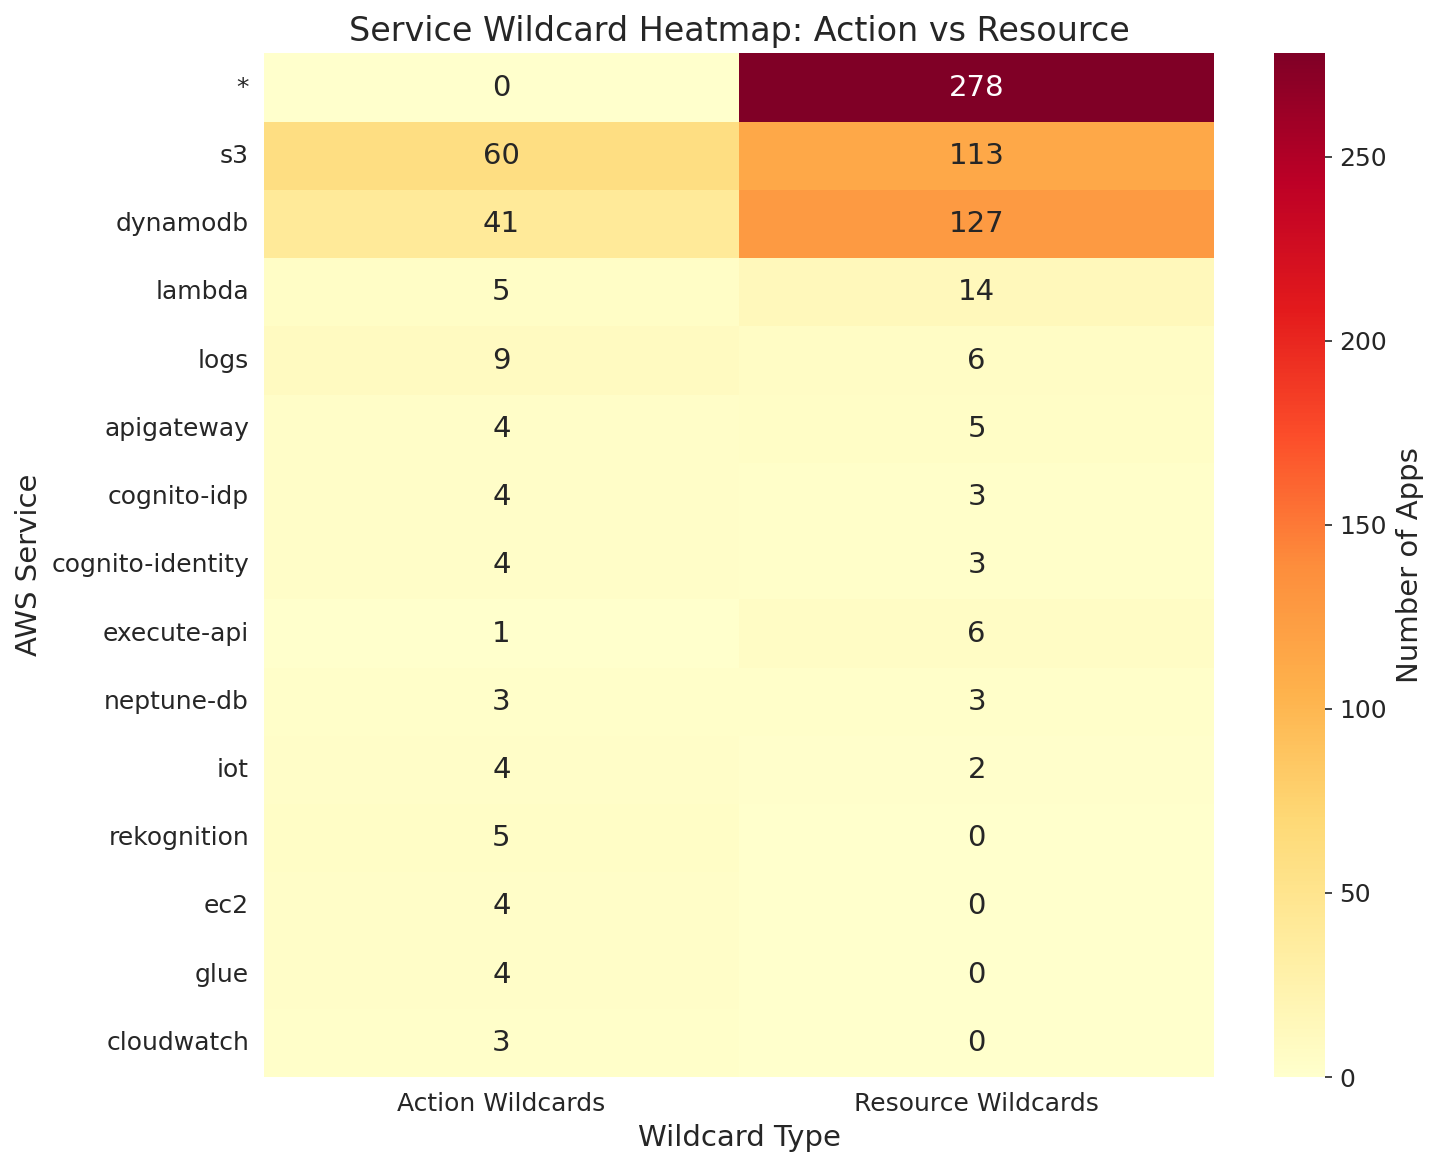

In [51]:
# Collect action wildcards by service
all_services_with_action_wildcards = []
for idx, row in df_policies.iterrows():
    if isinstance(row['action_wildcard_analysis'], dict):
        services = row['action_wildcard_analysis'].get('services_with_wildcards', [])
        all_services_with_action_wildcards.extend(services)

action_service_counts = pd.Series(all_services_with_action_wildcards).value_counts() if all_services_with_action_wildcards else pd.Series()

# Get top services that appear in either action or resource wildcards
all_wildcard_services = set(action_service_counts.head(15).index.tolist() if len(action_service_counts) > 0 else [])
if len(service_wildcard_counts) > 0:
    all_wildcard_services.update(service_wildcard_counts.head(15).index.tolist())

# Filter to services that appear (exclude 'unknown')
all_wildcard_services = [s for s in all_wildcard_services if s != 'unknown']
all_wildcard_services = sorted(all_wildcard_services)[:15]  # Limit to top 15

if all_wildcard_services:
    # Create heatmap data
    heatmap_data = []
    for service in all_wildcard_services:
        action_count = action_service_counts.get(service, 0) if len(action_service_counts) > 0 else 0
        resource_count = service_wildcard_counts.get(service, 0) if len(service_wildcard_counts) > 0 else 0
        heatmap_data.append([action_count, resource_count])
    
    heatmap_df = pd.DataFrame(heatmap_data, index=all_wildcard_services, columns=['Action Wildcards', 'Resource Wildcards'])
    
    # Sort by total wildcards
    heatmap_df['total'] = heatmap_df.sum(axis=1)
    heatmap_df = heatmap_df.sort_values('total', ascending=False).drop('total', axis=1)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(heatmap_df, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Number of Apps'})
    ax.set_title('Service Wildcard Heatmap: Action vs Resource')
    ax.set_xlabel('Wildcard Type')
    ax.set_ylabel('AWS Service')
    plt.tight_layout()
    plt.show()
else:
    print("No services with wildcards found for heatmap")

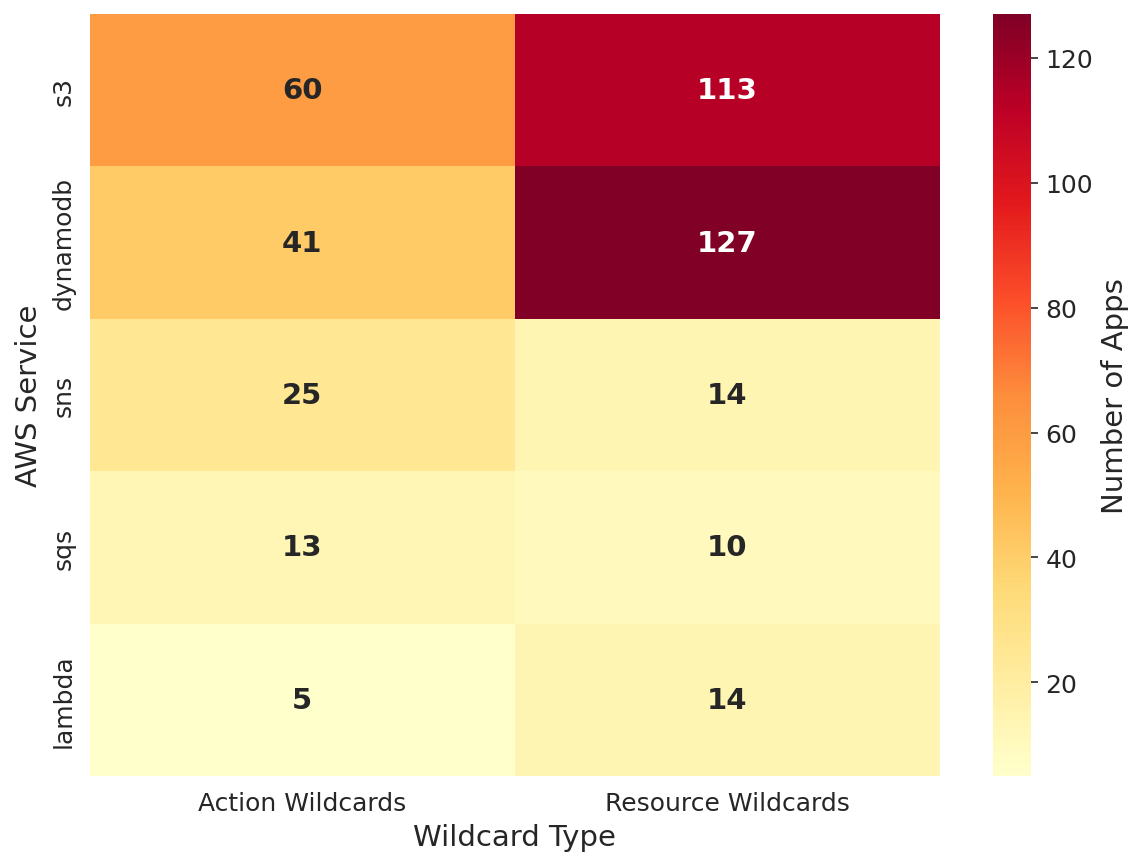

In [52]:
# repeat the analysis in the above cell but with the service "*" or "unknown" excluded
# Collect action wildcards by service (excluding '*' and 'unknown')
# limit to top 5 services

all_services_with_action_wildcards_excl_star = []
for idx, row in df_policies.iterrows():
    if isinstance(row['action_wildcard_analysis'], dict):
        services = row['action_wildcard_analysis'].get('services_with_wildcards', [])
        # Exclude the wildcard '*' and 'unknown'
        services = [svc for svc in services if svc != '*' and svc != 'unknown']
        all_services_with_action_wildcards_excl_star.extend(services)   
action_service_counts_excl_star = pd.Series(all_services_with_action_wildcards_excl_star).value_counts() if all_services_with_action_wildcards_excl_star else pd.Series() 
# Get top services that appear in either action or resource wildcards (excluding '*' and 'unknown')
all_wildcard_services_excl_star = set(action_service_counts_excl_star.head(4).index.tolist() if len(action_service_counts_excl_star) > 0 else [])
if len(service_wildcard_counts_excl_star) > 0:
    all_wildcard_services_excl_star.update(service_wildcard_counts_excl_star.head(4).index.tolist()) 
# Filter to services that appear (exclude 'unknown')
all_wildcard_services_excl_star = [s for s in all_wildcard_services_excl_star if s != 'unknown']
all_wildcard_services_excl_star = sorted(all_wildcard_services_excl_star)
#all_wildcard_services_excl_star = all_wildcard_services_excl_star[:5]  # Limit to top 5
if all_wildcard_services_excl_star:
    # Create heatmap data
    heatmap_data_excl_star = []
    for service in all_wildcard_services_excl_star:
        action_count = action_service_counts_excl_star.get(service, 0) if len(action_service_counts_excl_star) > 0 else 0
        resource_count = service_wildcard_counts_excl_star.get(service, 0) if len(service_wildcard_counts_excl_star) > 0 else 0
        heatmap_data_excl_star.append([action_count, resource_count])
    
    heatmap_df_excl_star = pd.DataFrame(heatmap_data_excl_star, index=all_wildcard_services_excl_star, columns=['Action Wildcards', 'Resource Wildcards'])
    
    # Sort by total wildcards
    heatmap_df_excl_star['total'] = heatmap_df_excl_star.sum(axis=1)
    heatmap_df_excl_star = heatmap_df_excl_star.sort_values('total', ascending=False).drop('total', axis=1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(heatmap_df_excl_star, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Number of Apps'},
                annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_xlabel('Wildcard Type', fontsize=14)
    ax.set_ylabel('AWS Service', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.show()

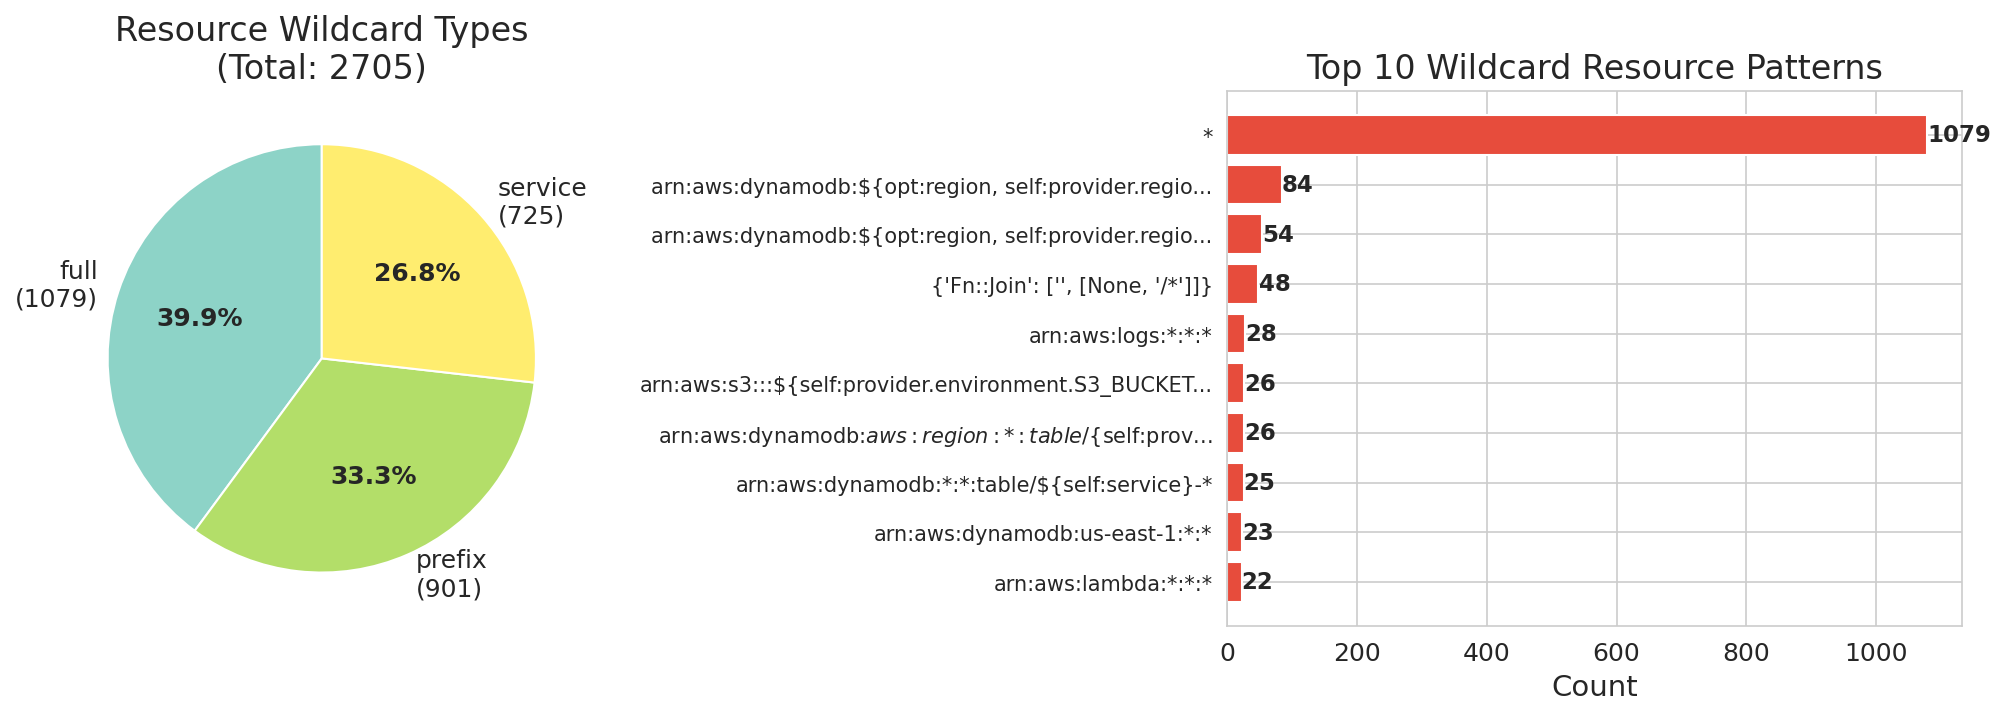


Total unique wildcard resource patterns: 292
Total wildcard resource occurrences: 2705


In [53]:
# Analyze actual wildcard resource patterns
all_wildcard_resources = []
for idx, row in df_policies.iterrows():
    if isinstance(row['resource_wildcard_analysis'], dict):
        resources = row['resource_wildcard_analysis'].get('wildcard_resources', [])
        for res in resources:
            if isinstance(res, dict):
                all_wildcard_resources.append({
                    'resource': res.get('resource', ''),
                    'type': res.get('type', ''),
                    'service': res.get('service', 'unknown')
                })

if all_wildcard_resources:
    wildcard_res_df = pd.DataFrame(all_wildcard_resources)
    
    # Show resource type distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Pie chart of wildcard types
    type_counts = wildcard_res_df['type'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
    wedges, texts, autotexts = axes[0].pie(type_counts.values, labels=[f'{t}\n({c})' for t, c in type_counts.items()], 
                colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    axes[0].set_title(f'Resource Wildcard Types\n(Total: {len(wildcard_res_df)})', fontsize=16)
    
    # Right: Top wildcard patterns
    pattern_counts = wildcard_res_df['resource'].value_counts().head(10)
    bars = axes[1].barh(range(len(pattern_counts)), pattern_counts.values, color='#e74c3c')
    axes[1].set_yticks(range(len(pattern_counts)))
    axes[1].set_yticklabels([p[:50] + '...' if len(p) > 50 else p for p in pattern_counts.index], fontsize=10)
    axes[1].set_xlabel('Count', fontsize=14)
    axes[1].set_title('Top 10 Wildcard Resource Patterns', fontsize=16)
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].invert_yaxis()
    
    for i, v in enumerate(pattern_counts.values):
        axes[1].text(v + 0.2, i, str(v), va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal unique wildcard resource patterns: {wildcard_res_df['resource'].nunique()}")
    print(f"Total wildcard resource occurrences: {len(wildcard_res_df)}")
else:
    print("No wildcard resources found")

## 8. Service Usage Analysis

Analyze which AWS services are most commonly used.

In [54]:
# Extract all services used across apps with policies
all_services = []
for idx, row in df_policies.iterrows():
    if isinstance(row['service_usage'], dict):
        all_services.extend(row['service_usage'].keys())

service_counts = pd.Series(all_services).value_counts()

print(f"Total unique services: {len(service_counts)}")
print("\nTop 15 most used services:")
print(service_counts.head(15))

Total unique services: 74

Top 15 most used services:
unknown        392
dynamodb       300
s3             195
sns             65
lambda          56
sqs             48
kinesis         40
xray            35
logs            33
ec2             24
ses             21
ssm             17
rekognition     15
iam             14
cloudwatch      14
Name: count, dtype: int64


## 9. Permission Statistics

Analyze the distribution of permissions across applications.

Permission Count Distribution (among 601 apps with policies):
count    601.000000
mean       4.820300
std        7.754202
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max      152.000000
Name: permission_stats, dtype: float64


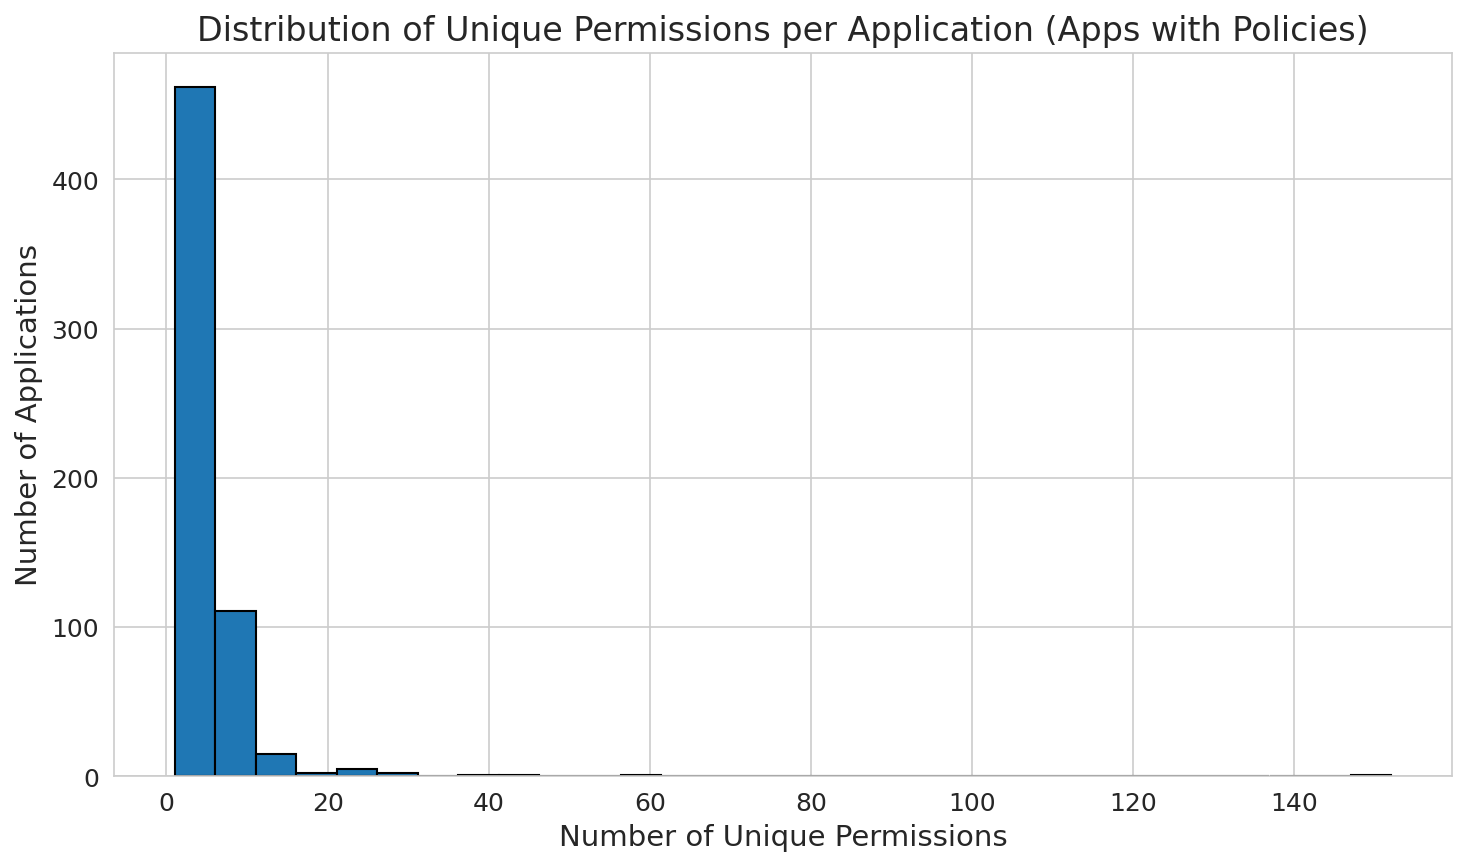

In [55]:
# Extract permission counts (for apps with policies)
permission_counts = df_policies['permission_stats'].apply(
    lambda x: x.get('total_unique_permissions', 0) if isinstance(x, dict) else 0
)

print(f"Permission Count Distribution (among {len(df_policies)} apps with policies):")
print(permission_counts.describe())

# Histogram of permission counts
fig, ax = plt.subplots(figsize=(10, 6))
permission_counts[permission_counts > 0].hist(bins=30, ax=ax, edgecolor='black')
ax.set_title('Distribution of Unique Permissions per Application (Apps with Policies)', fontsize=16)
ax.set_xlabel('Number of Unique Permissions', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

## 10. Dangerous Permissions Analysis

In [56]:
# Count apps with dangerous permissions (among apps with policies)
apps_with_dangerous = df_policies['dangerous_permissions'].apply(
    lambda x: len(x) > 0 if isinstance(x, dict) else False
)

print(f"Apps with dangerous permissions (delete/update): {apps_with_dangerous.sum()}")
print(f"Percentage (of apps with policies): {apps_with_dangerous.mean()*100:.1f}%")

# Collect all dangerous permissions
all_dangerous = []
for idx, row in df_policies.iterrows():
    if isinstance(row['dangerous_permissions'], dict):
        all_dangerous.extend(row['dangerous_permissions'].keys())

if all_dangerous:
    dangerous_counts = pd.Series(all_dangerous).value_counts()
    print("\nTop dangerous permissions:")
    print(dangerous_counts.head(10))

Apps with dangerous permissions (delete/update): 225
Percentage (of apps with policies): 37.4%

Top dangerous permissions:
dynamodb:DeleteItem                      152
dynamodb:UpdateItem                      141
s3:DeleteObject                           20
sqs:DeleteMessage                         14
ec2:DeleteNetworkInterface                14
dynamodb:DeleteTable                       4
iam:DeleteRolePolicy                       4
cognito-idp:AdminUpdateUserAttributes      3
rekognition:DeleteCollection               3
iam:DeleteRole                             3
Name: count, dtype: int64


## 11. Function-Level Analysis

Functions per Application (among 601 apps with policies):
count    601.000000
mean       2.851913
std        3.118178
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       26.000000
Name: num_functions, dtype: float64


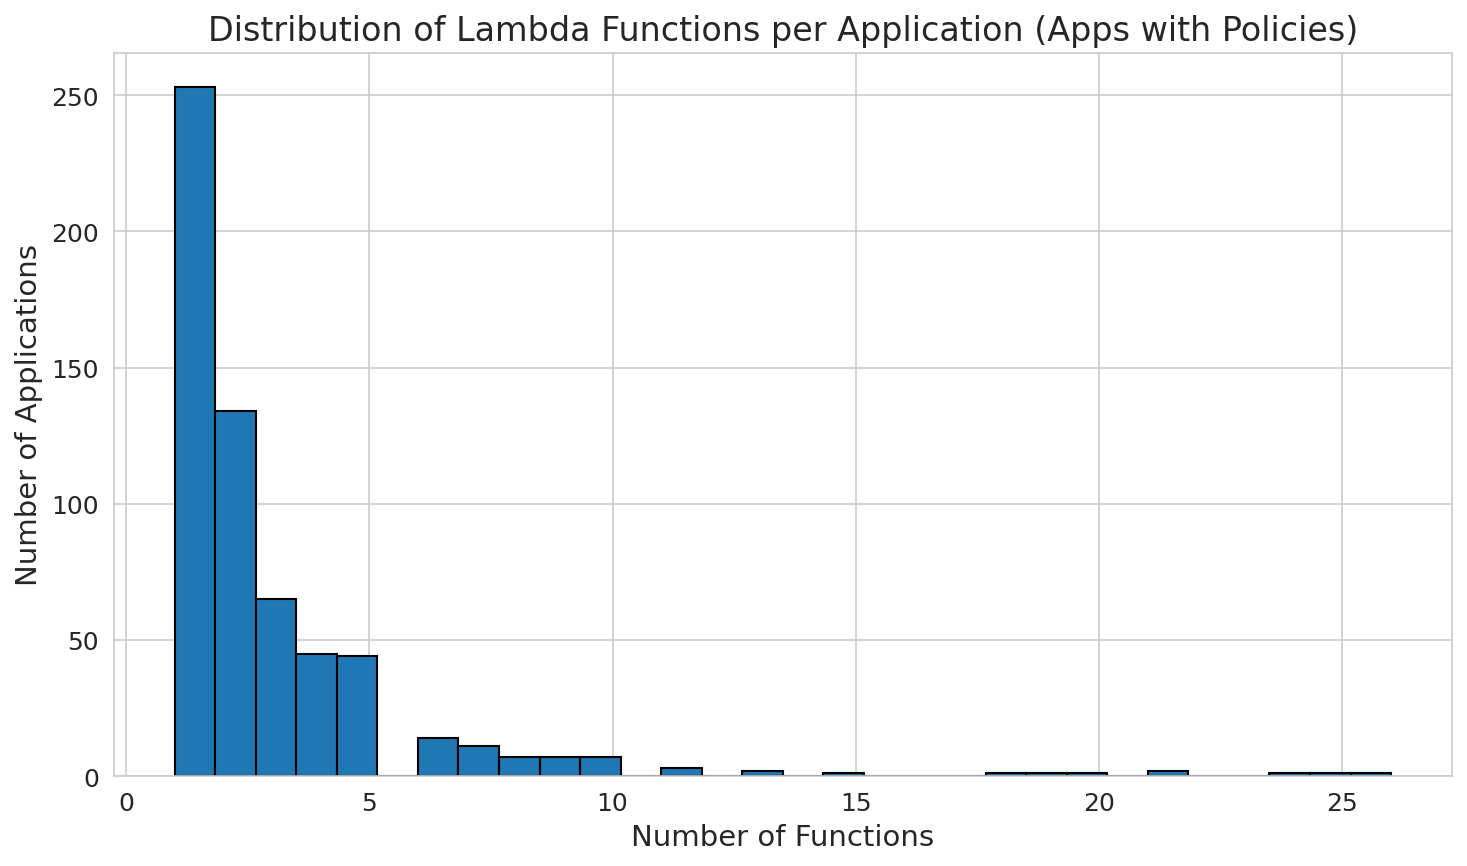

In [57]:
# Extract function counts (for apps with policies)
df_policies['num_functions'] = df_policies['analysis_metrics'].apply(
    lambda x: x.get('total_functions', 0) if isinstance(x, dict) else 0
)

print(f"Functions per Application (among {len(df_policies)} apps with policies):")
print(df_policies['num_functions'].describe())

# Distribution
fig, ax = plt.subplots(figsize=(10, 6))
df_policies['num_functions'].hist(bins=30, ax=ax, edgecolor='black')
ax.set_title('Distribution of Lambda Functions per Application (Apps with Policies)', fontsize=16)
ax.set_xlabel('Number of Functions', fontsize=14)
ax.set_ylabel('Number of Applications', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

## 12. Summary Statistics

In [58]:
# Comprehensive summary with all wildcard metrics
summary = {
    'Total Applications (all)': len(df),
    'Apps with No IAM Policy': df['has_no_iam_statements'].sum(),
    'Apps with IAM Policies (analyzed)': len(df_policies),
    'Apps with Global Policy Only': (df_policies['has_global_iam_statements'] & ~df_policies['has_function_level_iam_statements']).sum(),
    'Apps with Function Policy Only': (df_policies['has_function_level_iam_statements'] & ~df_policies['has_global_iam_statements']).sum(),
    'Apps with Both Policies': df_policies['has_both_global_and_function_iam_statements'].sum(),
    'Total Functions (apps with policies)': df_policies['num_functions'].sum(),
    'Avg Functions per App': round(df_policies['num_functions'].mean(), 2),
    'Total Unique Permissions': permission_counts.sum(),
    '--- Action Wildcards ---': '',
    'Apps with Any Action Wildcard': action_wildcard_df['action_has_any_wildcard'].sum(),
    'Apps with Full Action Wildcard (*)': action_wildcard_df['action_has_full_wildcard'].sum(),
    'Apps with Service Action Wildcard': action_wildcard_df['action_has_service_wildcard'].sum(),
    'Apps with Prefix Action Wildcard': action_wildcard_df['action_has_prefix_wildcard'].sum(),
    '--- Resource Wildcards ---': '',
    'Apps with Any Resource Wildcard': resource_wildcard_df['resource_has_any_wildcard'].sum(),
    'Apps with Full Resource Wildcard (*)': resource_wildcard_df['resource_has_full_wildcard'].sum(),
    'Apps with Service Resource Wildcard': resource_wildcard_df['resource_has_service_wildcard'].sum(),
    'Apps with Prefix Resource Wildcard': resource_wildcard_df['resource_has_prefix_wildcard'].sum(),
    '--- Combined Analysis ---': '',
    'Apps with Both Action & Resource WC': both,
    'Apps with Action WC Only': action_only,
    'Apps with Resource WC Only': resource_only,
    'Apps with No Wildcards': neither,
    'Apps with Dangerous Permissions': apps_with_dangerous.sum(),
}

summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])

# Display with styling
print("=" * 60)
print("COMPREHENSIVE POLICY ANALYSIS SUMMARY")
print("=" * 60)
for metric, value in summary.items():
    if str(value) == '':
        print(f"\n{metric}")
    else:
        print(f"  {metric}: {value}")
print("=" * 60)

summary_df

COMPREHENSIVE POLICY ANALYSIS SUMMARY
  Total Applications (all): 1731
  Apps with No IAM Policy: 1130
  Apps with IAM Policies (analyzed): 601
  Apps with Global Policy Only: 554
  Apps with Function Policy Only: 39
  Apps with Both Policies: 8
  Total Functions (apps with policies): 1714
  Avg Functions per App: 2.85
  Total Unique Permissions: 2897

--- Action Wildcards ---
  Apps with Any Action Wildcard: 146
  Apps with Full Action Wildcard (*): 6
  Apps with Service Action Wildcard: 130
  Apps with Prefix Action Wildcard: 15

--- Resource Wildcards ---
  Apps with Any Resource Wildcard: 493
  Apps with Full Resource Wildcard (*): 278
  Apps with Service Resource Wildcard: 121
  Apps with Prefix Resource Wildcard: 199

--- Combined Analysis ---
  Apps with Both Action & Resource WC: 129
  Apps with Action WC Only: 17
  Apps with Resource WC Only: 364
  Apps with No Wildcards: 91
  Apps with Dangerous Permissions: 225


,Metric,Value
0,Total Applications (all),1731
1,Apps with No IAM Policy,1130
2,Apps with IAM Policies (analyzed),601
3,Apps with Global Policy Only,554
4,Apps with Function Policy Only,39
5,Apps with Both Policies,8
6,Total Functions (apps with policies),1714
7,Avg Functions per App,2.85
8,Total Unique Permissions,2897
9,--- Action Wildcards ---,


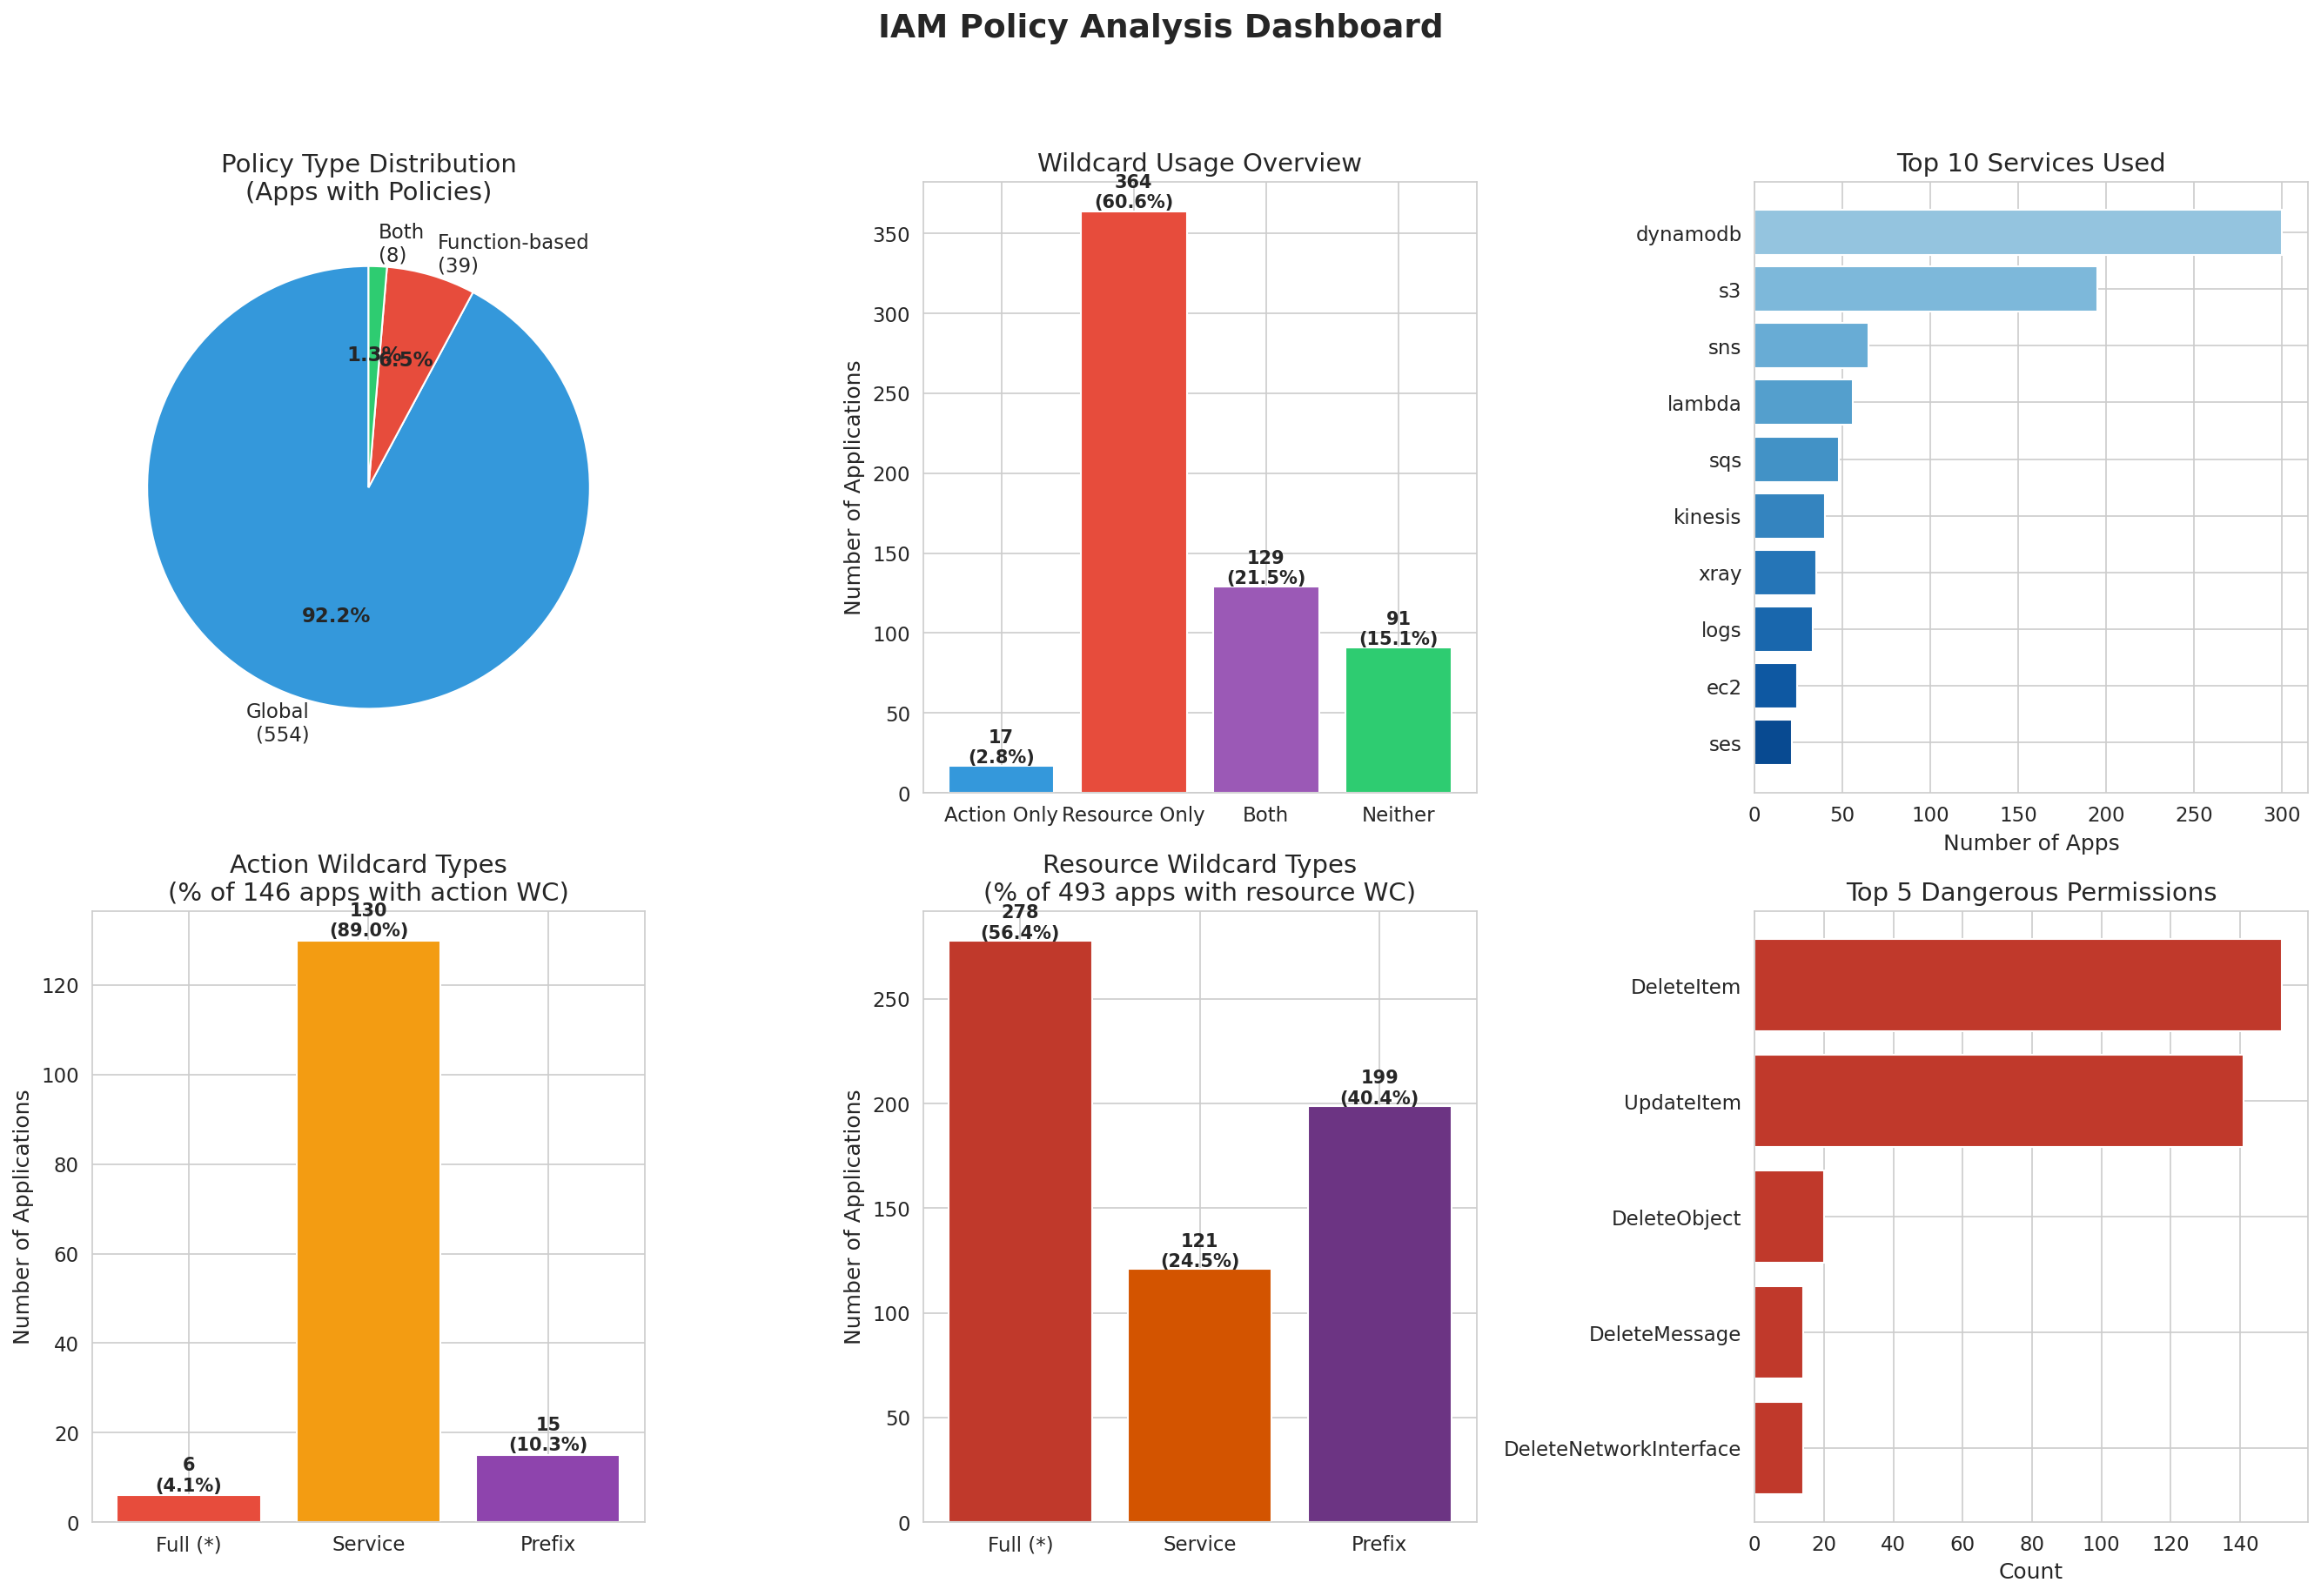

In [59]:
# Create a comprehensive dashboard visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Policy Type Distribution (Top Left)
policy_dist = df_policies['policy_type'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71']
wedges, texts, autotexts = axes[0, 0].pie(policy_dist.values, labels=[f'{l}\n({v})' for l, v in policy_dist.items()], 
               colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
axes[0, 0].set_title('Policy Type Distribution\n(Apps with Policies)', fontsize=14)

# 2. Wildcard Overview (Top Middle) - Apps with/without any wildcard
wildcard_summary = {
    'Action Only': action_only,
    'Resource Only': resource_only,
    'Both': both,
    'Neither': neither
}
colors = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']
bars = axes[0, 1].bar(wildcard_summary.keys(), wildcard_summary.values(), color=colors)
axes[0, 1].set_title('Wildcard Usage Overview', fontsize=14)
axes[0, 1].set_ylabel('Number of Applications', fontsize=12)
axes[0, 1].tick_params(axis='both', labelsize=11)
for bar in bars:
    height = bar.get_height()
    pct = (height / len(df_policies)) * 100 if len(df_policies) > 0 else 0
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# 3. Service Usage (Top Right)
top_services = service_counts[service_counts.index != 'unknown'].head(10)
axes[0, 2].barh(range(len(top_services)), top_services.values, color=plt.cm.Blues(np.linspace(0.4, 0.9, len(top_services))))
axes[0, 2].set_yticks(range(len(top_services)))
axes[0, 2].set_yticklabels(top_services.index, fontsize=11)
axes[0, 2].set_xlabel('Number of Apps', fontsize=12)
axes[0, 2].set_title('Top 10 Services Used', fontsize=14)
axes[0, 2].tick_params(axis='x', labelsize=11)
axes[0, 2].invert_yaxis()

# 4. Action Wildcard Types (Bottom Left) - Percentages relative to apps WITH action wildcards
action_types = {
    'Full (*)': action_wildcard_df['action_has_full_wildcard'].sum(),
    'Service': action_wildcard_df['action_has_service_wildcard'].sum(),
    'Prefix': action_wildcard_df['action_has_prefix_wildcard'].sum()
}
bars = axes[1, 0].bar(action_types.keys(), action_types.values(), color=['#e74c3c', '#f39c12', '#8e44ad'])
axes[1, 0].set_title(f'Action Wildcard Types\n(% of {total_with_action_wildcard} apps with action WC)', fontsize=14)
axes[1, 0].set_ylabel('Number of Applications', fontsize=12)
axes[1, 0].tick_params(axis='both', labelsize=11)
for i, (k, v) in enumerate(action_types.items()):
    pct = (v / total_with_action_wildcard) * 100 if total_with_action_wildcard > 0 else 0
    axes[1, 0].text(i, v + 1, f'{v}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# 5. Resource Wildcard Types (Bottom Middle) - Percentages relative to apps WITH resource wildcards
resource_types = {
    'Full (*)': resource_wildcard_df['resource_has_full_wildcard'].sum(),
    'Service': resource_wildcard_df['resource_has_service_wildcard'].sum(),
    'Prefix': resource_wildcard_df['resource_has_prefix_wildcard'].sum()
}
bars = axes[1, 1].bar(resource_types.keys(), resource_types.values(), color=['#c0392b', '#d35400', '#6c3483'])
axes[1, 1].set_title(f'Resource Wildcard Types\n(% of {total_with_resource_wildcard} apps with resource WC)', fontsize=14)
axes[1, 1].set_ylabel('Number of Applications', fontsize=12)
axes[1, 1].tick_params(axis='both', labelsize=11)
for i, (k, v) in enumerate(resource_types.items()):
    pct = (v / total_with_resource_wildcard) * 100 if total_with_resource_wildcard > 0 else 0
    axes[1, 1].text(i, v + 1, f'{v}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# 6. Dangerous Permissions (Bottom Right)
dangerous_types = pd.Series(all_dangerous).value_counts().head(5) if all_dangerous else pd.Series()
if len(dangerous_types) > 0:
    axes[1, 2].barh(range(len(dangerous_types)), dangerous_types.values, color='#c0392b')
    axes[1, 2].set_yticks(range(len(dangerous_types)))
    axes[1, 2].set_yticklabels([p.split(':')[1] if ':' in p else p for p in dangerous_types.index], fontsize=11)
    axes[1, 2].set_xlabel('Count', fontsize=12)
    axes[1, 2].set_title('Top 5 Dangerous Permissions', fontsize=14)
    axes[1, 2].tick_params(axis='x', labelsize=11)
    axes[1, 2].invert_yaxis()
else:
    axes[1, 2].text(0.5, 0.5, 'No dangerous permissions found', ha='center', va='center', fontsize=12)
    axes[1, 2].set_title('Dangerous Permissions', fontsize=14)

plt.suptitle('IAM Policy Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()